# Setup

## Imports & Variables

### Imports

In [1]:
import numpy as np
import os
import PIL
import tensorflow as tf
from matplotlib import pyplot as plt
import random
import math

from tensorflow.keras.models import Sequential

from keras.utils.np_utils import to_categorical

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import pandas as pd

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

from os import path
import pickle
import time

from collections import Counter

# example of semi-supervised gan for mnist
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Activation
from matplotlib import pyplot
from tensorflow.keras import backend

import cv2
import shutil

2023-07-15 02:11:51.043305: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]='0'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]

'0'

### Dataset & Model options

In [4]:
SB_DATASET = "DatasetSplitBalanced"
AB1000_DATASET = "DatasetAugmentedBalanced1000"
G_DATASET = "Synthetic_Dataset"
G_AND_AB_DATASET = "Synthetic_Dataset_AND_DatasetAugmentedBalanced1000"

DATASETS_OPTIONS = [SB_DATASET, AB1000_DATASET, G_DATASET, G_AND_AB_DATASET]

In [5]:
OPT_MODEL_MOBILENETV3_LARGE = 'MobileNetV3Large'
OPT_MODEL_XCEPTION = 'Xception'
OPT_MODEL_RESNET50V2 = 'ResNet50V2'
OPT_MODEL_VGG16 = 'VGG16'
OPT_MODEL_DENSENET121 = 'DenseNet121'
OPT_MODEL_INCEPTIONV3 = 'InceptionV3'

MODEL_OPTIONS = [OPT_MODEL_MOBILENETV3_LARGE, OPT_MODEL_XCEPTION, OPT_MODEL_RESNET50V2, OPT_MODEL_VGG16, OPT_MODEL_DENSENET121, OPT_MODEL_INCEPTIONV3]

In [6]:
SELECTED_DATASET = G_DATASET
EXCLUDED_MODELS = []

### Path & Model Variables

In [7]:
SB_DATASET_PATH = f"../dataset/{SB_DATASET}"
AB1000_DATASET_PATH = f"../dataset/{AB1000_DATASET}"
G_DATASET_PATH = "../dataset/DatasetGenerado"

FINAL_CNN_TRAIN_DATA_PATH = "../train_data/FINAL_CNN"
N_SAMPLES_PER_LABEL = {}
PARTITIONS = ["train", "validation", "test"]
PARTITION_COUNT = {"train": 4500, "validation": 495, "test": 5}
SHAPE_SIDE = 144
SHAPE = (SHAPE_SIDE,SHAPE_SIDE,3)
batch_size = 128
num_epochs = 300
TRAIN_THRESHOLD = 100

In [8]:
TEST_LOSS_DATA_FRAME = "/home/jbonastre/tfm/train_data/test_loss.csv"
TEST_ACC_DATA_FRAME = "/home/jbonastre/tfm/train_data/test_accuracy.csv"
TRAIN_TIME_DATA_FRAME = "/home/jbonastre/tfm/train_data/train_time.csv"

In [9]:
FOLDER_NAME = f"{SELECTED_DATASET}_{num_epochs}EPOCHS_{TRAIN_THRESHOLD}TRAIN_THRESHOLD"
DATASET_TRAIN_DATA_PATH = os.path.join(FINAL_CNN_TRAIN_DATA_PATH, FOLDER_NAME)

In [10]:
print(DATASET_TRAIN_DATA_PATH)

../train_data/FINAL_CNN/Synthetic_Dataset_300EPOCHS_100TRAIN_THRESHOLD


### Delete Train Data for Dataset

In [11]:
def delete_train_data():
    print(f"Deleting train data of DATASET {SELECTED_DATASET}")
    if(not os.path.isdir(DATASET_TRAIN_DATA_PATH)): return
    model_folders = os.listdir(DATASET_TRAIN_DATA_PATH)
    for model_folder in [m for m in model_folders if m not in EXCLUDED_MODELS]:
        model_path = os.path.join(DATASET_TRAIN_DATA_PATH,model_folder)
        print(f"\tDeleting {model_path}")
        if(os.path.isdir(model_path)): shutil.rmtree(model_path)

# delete_train_data(X)

### Make dirs for datasets and models

In [12]:
def check_train_data_dirs():
    print(f"Checking train data folder: {FINAL_CNN_TRAIN_DATA_PATH}\n")
    if(not os.path.exists(FINAL_CNN_TRAIN_DATA_PATH)): os.mkdir(FINAL_CNN_TRAIN_DATA_PATH)

    print(f"Checking dataset folder: {DATASET_TRAIN_DATA_PATH}")
    if(not os.path.exists(DATASET_TRAIN_DATA_PATH)): os.mkdir(DATASET_TRAIN_DATA_PATH)

    for model_option in [m for m in MODEL_OPTIONS if m not in EXCLUDED_MODELS]:
        dataset_model_path = os.path.join(DATASET_TRAIN_DATA_PATH, model_option)
        print(f"\tChecking model folder: {dataset_model_path}")
        if(not os.path.exists(dataset_model_path)): os.mkdir(dataset_model_path)

    #         if(SELECTED_DATASET == dataset_option and SELECTED_MODEL == model_option):
    #             selected_train_data_path = dataset_model_path
    #             print(f"\nSELECTED dataset and model path: {dataset_model_path}")

### Check Pandas Dataframe

In [13]:
def check_data_frame(path):
    if (not os.path.isfile(path)):
        df = pd.DataFrame({
            OPT_MODEL_DENSENET121: [],
            OPT_MODEL_INCEPTIONV3: [],
            OPT_MODEL_MOBILENETV3_LARGE: [],
            OPT_MODEL_RESNET50V2: [],
            OPT_MODEL_VGG16: [],
            OPT_MODEL_XCEPTION: [],
            "Average": []
        })
        df.to_csv(path, index=False)
    else:
        df = pd.read_csv(path, index_col=0)
    return df

test_loss_df = check_data_frame(TEST_LOSS_DATA_FRAME)
test_acc_df = check_data_frame(TEST_ACC_DATA_FRAME)
train_time_df = check_data_frame(TRAIN_TIME_DATA_FRAME)

test_loss_data = {"df": test_loss_df, "path": TEST_LOSS_DATA_FRAME}
test_acc_data = {"df": test_acc_df, "path": TEST_ACC_DATA_FRAME}
train_time_data = {"df": train_time_df, "path": TRAIN_TIME_DATA_FRAME}

In [14]:
def add_single_value(df, column, value):
    if FOLDER_NAME not in df.index:
        df.loc[FOLDER_NAME] = pd.Series()
    df.at[FOLDER_NAME, column] = value
    return df

In [15]:
def update_df(df_data, column, value):
    df_data['df'] = add_single_value(df_data['df'], column, value)
    df_data['df'].to_csv(df_data['path'], index=True)

In [16]:
def calculate_average_df(df):
    column_names = [OPT_MODEL_DENSENET121, OPT_MODEL_INCEPTIONV3, OPT_MODEL_MOBILENETV3_LARGE, OPT_MODEL_RESNET50V2, OPT_MODEL_VGG16, OPT_MODEL_XCEPTION]
    selected_columns  = df.loc[FOLDER_NAME, column_names]
    return selected_columns .mean()
    

### Label Constants

In [17]:
LABELS = ["BAS","EBO","EOS","KSC","LYA","LYT","MMZ","MOB","MON","MYB","MYO","NGB","NGS","PMB","PMO"]
num_classes= len(LABELS)
CODE_TO_LABEL = {
    0:"BAS",
    1:"EBO",
    2:"EOS",
    3:"KSC",
    4:"LYA",
    5:"LYT",
    6:"MMZ",
    7:"MOB",
    8:"MON",
    9:"MYB",
    10:"MYO",
    11:"NGB",
    12:"NGS",
    13:"PMB",
    14:"PMO",
}
LABEL_TO_CODE = {
    "BAS":0,
    "EBO":1,
    "EOS":2,
    "KSC":3,
    "LYA":4,
    "LYT":5,
    "MMZ":6,
    "MOB":7,
    "MON":8,
    "MYB":9,
    "MYO":10,
    "NGB":11,
    "NGS":12,
    "PMB":13,
    "PMO":14,
}
LABELS_ABREVIATIONS = {
    "BAS": "Basophil",
    "EBO": "Erythroblast",
    "EOS": "Eosinophil",
    "KSC": "Smudge cell",
    "LYA": "Lymphocyte (atypical)",
    "LYT": "Lymphocyte (typical)",
    "MMZ": "Metamyelocyte",
    "MOB": "Monoblast",
    "MON": "Monocyte",
    "MYB": "Myelocyte",
    "MYO": "Myeloblast",
    "NGB": "Neutrophil (band)",
    "NGS": "Neutrophil (segmented)",
    "PMB": "Promyelocyte (bilobled)",
    "PMO": "Promyelocyte",
}

## Read dataset

In [18]:
# Code used to clean the dataset with somo undesired files
#         if(img_path.endswith(".ipynb_checkpoints")):
#             print(f"LO TIENE: {img_path}")
#             shutil.rmtree(img_path)
#             continue
#         if(img_path.endswith("desktop.ini")):
#             print(f"LO TIENE: {img_path}")
#             os.remove(img_path)
#             continue

In [19]:
train_images = []
train_labels = []
val_images = []
val_labels = []
test_images = []
test_labels = []

In [20]:
def split_sample_to_partition(image, label, partition):
  if partition == 'train':
    train_images.append(image)
    train_labels.append(label)
  elif partition == 'validation':
    val_images.append(image)
    val_labels.append(label)
  elif partition == 'test':
    test_images.append(image)
    test_labels.append(label)

In [21]:
def check_partitions_count(dataset_path):
  for label in LABELS:
    label_code = LABEL_TO_CODE[label]
    checks = []
    print(f"Checking sample count for {label}:")
    for partition in PARTITIONS:
      labels_path = os.path.join(dataset_path,partition)
      label_text = CODE_TO_LABEL[label_code]
      label_path = os.path.join(dataset_path,partition, label_text)
      label_images = os.listdir(label_path)
      count = len(label_images)
      N_SAMPLES_PER_LABEL[label_text] = count
      print(f"Expected sample count: {PARTITION_COUNT[partition]}\t observed: {count}")
      if (count < PARTITION_COUNT[partition]): checks.append(False)
      else: checks.append(True)
    if False in checks:
      raise Exception("Unexpected number of samples")
    else:
      print("OK. expected number of samples")

In [22]:
def read_from_dataset(dataset_path):
  images = []
  labels = []
  for label_text in LABELS:
    label_code = LABEL_TO_CODE[label_text]
    label_path = os.path.join(dataset_path, label_text)
    label_images = os.listdir(label_path)

    print(label_path)
    print(len(label_images))
    for j,img_text in enumerate(label_images):
      print(f"\t{label_text}: {j}. {img_text}")

      img_path = os.path.join(dataset_path,label_text,img_text)
      img = np.array(PIL.Image.open(img_path))[:,:,:3]
      img = cv2.resize(img, (SHAPE_SIDE, SHAPE_SIDE))

      label = to_categorical(LABEL_TO_CODE[label_text],num_classes)

      images.append(img)
      labels.append(label)
  return images, labels

In [23]:
def read_from_dataset_with_partitions(dataset_path, train_to_val=False):
  for label_text in LABELS:
    label_code = LABEL_TO_CODE[label_text]
    for partition in PARTITIONS:
      # When using synthetic data i want all train data to be synthetic and use the original data just for validation.
      if(partition=='train' and train_to_val==True):
        save_partition = 'validation'
      else:
        save_partition = partition
      labels_path = os.path.join(dataset_path,partition)
      labels_texts = os.listdir(labels_path)
      n_labels = len(labels_texts)
      label_path = os.path.join(dataset_path,partition, label_text)
      label_images = os.listdir(label_path)
      print(label_path)
      print(len(label_images))
      for j,img_text in enumerate(label_images):
        if(partition=='train' and j>=TRAIN_THRESHOLD and SELECTED_DATASET==SB_DATASET): continue
        print(f"{partition} {label_text}: {j}. {img_text}")
        img_path = os.path.join(dataset_path,partition,label_text,img_text)
        img = np.array(PIL.Image.open(img_path))[:,:,:3]
        img = cv2.resize(img, (SHAPE_SIDE, SHAPE_SIDE))
        split_sample_to_partition(img, to_categorical(LABEL_TO_CODE[label_text],n_labels), save_partition)

In [24]:
if (SELECTED_DATASET==SB_DATASET):
    read_from_dataset_with_partitions(SB_DATASET_PATH)

if (SELECTED_DATASET==AB1000_DATASET):
    #   check_partitions_count(AB1000_DATASET_PATH)
    read_from_dataset_with_partitions(AB1000_DATASET_PATH)

if (SELECTED_DATASET==G_DATASET):
    read_from_dataset_with_partitions(SB_DATASET_PATH, train_to_val=False)
    gen_train_images, gen_train_labels = read_from_dataset(G_DATASET_PATH)
    train_images = gen_train_images
    train_labels = gen_train_labels
    
if (SELECTED_DATASET==G_AND_AB_DATASET):
    read_from_dataset_with_partitions(SB_DATASET_PATH, train_to_val=False)
    gen_train_images, gen_train_labels = read_from_dataset(G_DATASET_PATH)
    train_images = train_images + gen_train_images
    train_labels = train_labels + gen_train_labels


../dataset/DatasetSplitBalanced/train/BAS
73
train BAS: 0. TRAIN_19_BAS.bmp
train BAS: 1. TRAIN_58_BAS.bmp
train BAS: 2. TRAIN_15_BAS.bmp
train BAS: 3. TRAIN_64_BAS.bmp
train BAS: 4. TRAIN_34_BAS.bmp
train BAS: 5. TRAIN_50_BAS.bmp
train BAS: 6. TRAIN_52_BAS.bmp
train BAS: 7. TRAIN_11_BAS.bmp
train BAS: 8. TRAIN_44_BAS.bmp
train BAS: 9. TRAIN_17_BAS.bmp
train BAS: 10. TRAIN_47_BAS.bmp
train BAS: 11. TRAIN_54_BAS.bmp
train BAS: 12. TRAIN_69_BAS.bmp
train BAS: 13. TRAIN_10_BAS.bmp
train BAS: 14. TRAIN_18_BAS.bmp
train BAS: 15. TRAIN_38_BAS.bmp
train BAS: 16. TRAIN_24_BAS.bmp
train BAS: 17. TRAIN_56_BAS.bmp
train BAS: 18. TRAIN_67_BAS.bmp
train BAS: 19. TRAIN_60_BAS.bmp
train BAS: 20. TRAIN_23_BAS.bmp
train BAS: 21. TRAIN_39_BAS.bmp
train BAS: 22. TRAIN_26_BAS.bmp
train BAS: 23. TRAIN_27_BAS.bmp
train BAS: 24. TRAIN_28_BAS.bmp
train BAS: 25. TRAIN_35_BAS.bmp
train BAS: 26. TRAIN_72_BAS.bmp
train BAS: 27. TRAIN_62_BAS.bmp
train BAS: 28. TRAIN_4_BAS.bmp
train BAS: 29. TRAIN_49_BAS.bmp
train 

train LYT: 116. TRAIN_3091_LYT.bmp
train LYT: 117. TRAIN_1670_LYT.bmp
train LYT: 118. TRAIN_2855_LYT.bmp
train LYT: 119. TRAIN_804_LYT.bmp
train LYT: 120. TRAIN_3148_LYT.bmp
train LYT: 121. TRAIN_2700_LYT.bmp
train LYT: 122. TRAIN_660_LYT.bmp
train LYT: 123. TRAIN_2058_LYT.bmp
train LYT: 124. TRAIN_35_LYT.bmp
train LYT: 125. TRAIN_3755_LYT.bmp
train LYT: 126. TRAIN_3619_LYT.bmp
train LYT: 127. TRAIN_512_LYT.bmp
train LYT: 128. TRAIN_188_LYT.bmp
train LYT: 129. TRAIN_3095_LYT.bmp
train LYT: 130. TRAIN_1872_LYT.bmp
train LYT: 131. TRAIN_1934_LYT.bmp
train LYT: 132. TRAIN_3674_LYT.bmp
train LYT: 133. TRAIN_1644_LYT.bmp
train LYT: 134. TRAIN_3135_LYT.bmp
train LYT: 135. TRAIN_313_LYT.bmp
train LYT: 136. TRAIN_3183_LYT.bmp
train LYT: 137. TRAIN_3747_LYT.bmp
train LYT: 138. TRAIN_1719_LYT.bmp
train LYT: 139. TRAIN_1842_LYT.bmp
train LYT: 140. TRAIN_623_LYT.bmp
train LYT: 141. TRAIN_1720_LYT.bmp
train LYT: 142. TRAIN_3220_LYT.bmp
train LYT: 143. TRAIN_2875_LYT.bmp
train LYT: 144. TRAIN_1270_L

train LYT: 524. TRAIN_3913_LYT.bmp
train LYT: 525. TRAIN_2878_LYT.bmp
train LYT: 526. TRAIN_3126_LYT.bmp
train LYT: 527. TRAIN_1344_LYT.bmp
train LYT: 528. TRAIN_307_LYT.bmp
train LYT: 529. TRAIN_2502_LYT.bmp
train LYT: 530. TRAIN_3368_LYT.bmp
train LYT: 531. TRAIN_3912_LYT.bmp
train LYT: 532. TRAIN_1908_LYT.bmp
train LYT: 533. TRAIN_3608_LYT.bmp
train LYT: 534. TRAIN_216_LYT.bmp
train LYT: 535. TRAIN_611_LYT.bmp
train LYT: 536. TRAIN_3430_LYT.bmp
train LYT: 537. TRAIN_2785_LYT.bmp
train LYT: 538. TRAIN_3329_LYT.bmp
train LYT: 539. TRAIN_376_LYT.bmp
train LYT: 540. TRAIN_2575_LYT.bmp
train LYT: 541. TRAIN_2719_LYT.bmp
train LYT: 542. TRAIN_861_LYT.bmp
train LYT: 543. TRAIN_2404_LYT.bmp
train LYT: 544. TRAIN_3573_LYT.bmp
train LYT: 545. TRAIN_1778_LYT.bmp
train LYT: 546. TRAIN_2530_LYT.bmp
train LYT: 547. TRAIN_3795_LYT.bmp
train LYT: 548. TRAIN_2138_LYT.bmp
train LYT: 549. TRAIN_2354_LYT.bmp
train LYT: 550. TRAIN_2470_LYT.bmp
train LYT: 551. TRAIN_3097_LYT.bmp
train LYT: 552. TRAIN_58_

train LYT: 1292. TRAIN_2359_LYT.bmp
train LYT: 1293. TRAIN_1935_LYT.bmp
train LYT: 1294. TRAIN_3272_LYT.bmp
train LYT: 1295. TRAIN_3870_LYT.bmp
train LYT: 1296. TRAIN_1893_LYT.bmp
train LYT: 1297. TRAIN_810_LYT.bmp
train LYT: 1298. TRAIN_3177_LYT.bmp
train LYT: 1299. TRAIN_3660_LYT.bmp
train LYT: 1300. TRAIN_1675_LYT.bmp
train LYT: 1301. TRAIN_1171_LYT.bmp
train LYT: 1302. TRAIN_55_LYT.bmp
train LYT: 1303. TRAIN_139_LYT.bmp
train LYT: 1304. TRAIN_1186_LYT.bmp
train LYT: 1305. TRAIN_2860_LYT.bmp
train LYT: 1306. TRAIN_3919_LYT.bmp
train LYT: 1307. TRAIN_1607_LYT.bmp
train LYT: 1308. TRAIN_3182_LYT.bmp
train LYT: 1309. TRAIN_3448_LYT.bmp
train LYT: 1310. TRAIN_3037_LYT.bmp
train LYT: 1311. TRAIN_1806_LYT.bmp
train LYT: 1312. TRAIN_2218_LYT.bmp
train LYT: 1313. TRAIN_2299_LYT.bmp
train LYT: 1314. TRAIN_1352_LYT.bmp
train LYT: 1315. TRAIN_1604_LYT.bmp
train LYT: 1316. TRAIN_2417_LYT.bmp
train LYT: 1317. TRAIN_1830_LYT.bmp
train LYT: 1318. TRAIN_1369_LYT.bmp
train LYT: 1319. TRAIN_1722_LYT.

train LYT: 1696. TRAIN_2898_LYT.bmp
train LYT: 1697. TRAIN_1627_LYT.bmp
train LYT: 1698. TRAIN_2265_LYT.bmp
train LYT: 1699. TRAIN_2758_LYT.bmp
train LYT: 1700. TRAIN_875_LYT.bmp
train LYT: 1701. TRAIN_3916_LYT.bmp
train LYT: 1702. TRAIN_3769_LYT.bmp
train LYT: 1703. TRAIN_2775_LYT.bmp
train LYT: 1704. TRAIN_1637_LYT.bmp
train LYT: 1705. TRAIN_1883_LYT.bmp
train LYT: 1706. TRAIN_1949_LYT.bmp
train LYT: 1707. TRAIN_964_LYT.bmp
train LYT: 1708. TRAIN_1230_LYT.bmp
train LYT: 1709. TRAIN_1767_LYT.bmp
train LYT: 1710. TRAIN_3505_LYT.bmp
train LYT: 1711. TRAIN_2108_LYT.bmp
train LYT: 1712. TRAIN_2942_LYT.bmp
train LYT: 1713. TRAIN_1655_LYT.bmp
train LYT: 1714. TRAIN_656_LYT.bmp
train LYT: 1715. TRAIN_253_LYT.bmp
train LYT: 1716. TRAIN_1256_LYT.bmp
train LYT: 1717. TRAIN_3117_LYT.bmp
train LYT: 1718. TRAIN_3530_LYT.bmp
train LYT: 1719. TRAIN_219_LYT.bmp
train LYT: 1720. TRAIN_1967_LYT.bmp
train LYT: 1721. TRAIN_3868_LYT.bmp
train LYT: 1722. TRAIN_1105_LYT.bmp
train LYT: 1723. TRAIN_2809_LYT.b

train LYT: 2478. TRAIN_2910_LYT.bmp
train LYT: 2479. TRAIN_1011_LYT.bmp
train LYT: 2480. TRAIN_949_LYT.bmp
train LYT: 2481. TRAIN_1985_LYT.bmp
train LYT: 2482. TRAIN_2626_LYT.bmp
train LYT: 2483. TRAIN_1692_LYT.bmp
train LYT: 2484. TRAIN_1306_LYT.bmp
train LYT: 2485. TRAIN_2245_LYT.bmp
train LYT: 2486. TRAIN_3292_LYT.bmp
train LYT: 2487. TRAIN_3927_LYT.bmp
train LYT: 2488. TRAIN_2786_LYT.bmp
train LYT: 2489. TRAIN_3582_LYT.bmp
train LYT: 2490. TRAIN_1463_LYT.bmp
train LYT: 2491. TRAIN_276_LYT.bmp
train LYT: 2492. TRAIN_1314_LYT.bmp
train LYT: 2493. TRAIN_2953_LYT.bmp
train LYT: 2494. TRAIN_308_LYT.bmp
train LYT: 2495. TRAIN_2455_LYT.bmp
train LYT: 2496. TRAIN_125_LYT.bmp
train LYT: 2497. TRAIN_3163_LYT.bmp
train LYT: 2498. TRAIN_3730_LYT.bmp
train LYT: 2499. TRAIN_879_LYT.bmp
train LYT: 2500. TRAIN_1680_LYT.bmp
train LYT: 2501. TRAIN_1501_LYT.bmp
train LYT: 2502. TRAIN_6_LYT.bmp
train LYT: 2503. TRAIN_2825_LYT.bmp
train LYT: 2504. TRAIN_3123_LYT.bmp
train LYT: 2505. TRAIN_690_LYT.bmp
t

train LYT: 2880. TRAIN_3256_LYT.bmp
train LYT: 2881. TRAIN_2054_LYT.bmp
train LYT: 2882. TRAIN_349_LYT.bmp
train LYT: 2883. TRAIN_2121_LYT.bmp
train LYT: 2884. TRAIN_2594_LYT.bmp
train LYT: 2885. TRAIN_1052_LYT.bmp
train LYT: 2886. TRAIN_1337_LYT.bmp
train LYT: 2887. TRAIN_2156_LYT.bmp
train LYT: 2888. TRAIN_2913_LYT.bmp
train LYT: 2889. TRAIN_2697_LYT.bmp
train LYT: 2890. TRAIN_3572_LYT.bmp
train LYT: 2891. TRAIN_762_LYT.bmp
train LYT: 2892. TRAIN_1366_LYT.bmp
train LYT: 2893. TRAIN_761_LYT.bmp
train LYT: 2894. TRAIN_976_LYT.bmp
train LYT: 2895. TRAIN_3078_LYT.bmp
train LYT: 2896. TRAIN_1454_LYT.bmp
train LYT: 2897. TRAIN_621_LYT.bmp
train LYT: 2898. TRAIN_3341_LYT.bmp
train LYT: 2899. TRAIN_2760_LYT.bmp
train LYT: 2900. TRAIN_2096_LYT.bmp
train LYT: 2901. TRAIN_3136_LYT.bmp
train LYT: 2902. TRAIN_1431_LYT.bmp
train LYT: 2903. TRAIN_2774_LYT.bmp
train LYT: 2904. TRAIN_1965_LYT.bmp
train LYT: 2905. TRAIN_673_LYT.bmp
train LYT: 2906. TRAIN_3779_LYT.bmp
train LYT: 2907. TRAIN_3032_LYT.bm

train LYT: 3659. TRAIN_722_LYT.bmp
train LYT: 3660. TRAIN_2652_LYT.bmp
train LYT: 3661. TRAIN_1835_LYT.bmp
train LYT: 3662. TRAIN_715_LYT.bmp
train LYT: 3663. TRAIN_3877_LYT.bmp
train LYT: 3664. TRAIN_2765_LYT.bmp
train LYT: 3665. TRAIN_3692_LYT.bmp
train LYT: 3666. TRAIN_2003_LYT.bmp
train LYT: 3667. TRAIN_694_LYT.bmp
train LYT: 3668. TRAIN_2723_LYT.bmp
train LYT: 3669. TRAIN_2075_LYT.bmp
train LYT: 3670. TRAIN_1551_LYT.bmp
train LYT: 3671. TRAIN_3881_LYT.bmp
train LYT: 3672. TRAIN_1430_LYT.bmp
train LYT: 3673. TRAIN_1059_LYT.bmp
train LYT: 3674. TRAIN_1586_LYT.bmp
train LYT: 3675. TRAIN_140_LYT.bmp
train LYT: 3676. TRAIN_3752_LYT.bmp
train LYT: 3677. TRAIN_2922_LYT.bmp
train LYT: 3678. TRAIN_1242_LYT.bmp
train LYT: 3679. TRAIN_3439_LYT.bmp
train LYT: 3680. TRAIN_2476_LYT.bmp
train LYT: 3681. TRAIN_2106_LYT.bmp
train LYT: 3682. TRAIN_3284_LYT.bmp
train LYT: 3683. TRAIN_1296_LYT.bmp
train LYT: 3684. TRAIN_2135_LYT.bmp
train LYT: 3685. TRAIN_627_LYT.bmp
train LYT: 3686. TRAIN_2599_LYT.b

train MON: 81. TRAIN_1365_MON.bmp
train MON: 82. TRAIN_1528_MON.bmp
train MON: 83. TRAIN_94_MON.bmp
train MON: 84. TRAIN_469_MON.bmp
train MON: 85. TRAIN_481_MON.bmp
train MON: 86. TRAIN_1761_MON.bmp
train MON: 87. TRAIN_1314_MON.bmp
train MON: 88. TRAIN_581_MON.bmp
train MON: 89. TRAIN_1007_MON.bmp
train MON: 90. TRAIN_926_MON.bmp
train MON: 91. TRAIN_688_MON.bmp
train MON: 92. TRAIN_1450_MON.bmp
train MON: 93. TRAIN_1552_MON.bmp
train MON: 94. TRAIN_649_MON.bmp
train MON: 95. TRAIN_192_MON.bmp
train MON: 96. TRAIN_327_MON.bmp
train MON: 97. TRAIN_1106_MON.bmp
train MON: 98. TRAIN_504_MON.bmp
train MON: 99. TRAIN_789_MON.bmp
train MON: 100. TRAIN_1769_MON.bmp
train MON: 101. TRAIN_947_MON.bmp
train MON: 102. TRAIN_479_MON.bmp
train MON: 103. TRAIN_305_MON.bmp
train MON: 104. TRAIN_621_MON.bmp
train MON: 105. TRAIN_218_MON.bmp
train MON: 106. TRAIN_1581_MON.bmp
train MON: 107. TRAIN_717_MON.bmp
train MON: 108. TRAIN_421_MON.bmp
train MON: 109. TRAIN_1749_MON.bmp
train MON: 110. TRAIN_7

train MON: 871. TRAIN_918_MON.bmp
train MON: 872. TRAIN_531_MON.bmp
train MON: 873. TRAIN_849_MON.bmp
train MON: 874. TRAIN_583_MON.bmp
train MON: 875. TRAIN_496_MON.bmp
train MON: 876. TRAIN_935_MON.bmp
train MON: 877. TRAIN_1168_MON.bmp
train MON: 878. TRAIN_1111_MON.bmp
train MON: 879. TRAIN_1231_MON.bmp
train MON: 880. TRAIN_232_MON.bmp
train MON: 881. TRAIN_1274_MON.bmp
train MON: 882. TRAIN_1478_MON.bmp
train MON: 883. TRAIN_1628_MON.bmp
train MON: 884. TRAIN_1663_MON.bmp
train MON: 885. TRAIN_30_MON.bmp
train MON: 886. TRAIN_1743_MON.bmp
train MON: 887. TRAIN_1250_MON.bmp
train MON: 888. TRAIN_1071_MON.bmp
train MON: 889. TRAIN_383_MON.bmp
train MON: 890. TRAIN_343_MON.bmp
train MON: 891. TRAIN_1398_MON.bmp
train MON: 892. TRAIN_1406_MON.bmp
train MON: 893. TRAIN_1376_MON.bmp
train MON: 894. TRAIN_1402_MON.bmp
train MON: 895. TRAIN_1004_MON.bmp
train MON: 896. TRAIN_767_MON.bmp
train MON: 897. TRAIN_72_MON.bmp
train MON: 898. TRAIN_564_MON.bmp
train MON: 899. TRAIN_851_MON.bmp
t

train MON: 1279. TRAIN_914_MON.bmp
train MON: 1280. TRAIN_1577_MON.bmp
train MON: 1281. TRAIN_1336_MON.bmp
train MON: 1282. TRAIN_869_MON.bmp
train MON: 1283. TRAIN_1237_MON.bmp
train MON: 1284. TRAIN_1407_MON.bmp
train MON: 1285. TRAIN_1714_MON.bmp
train MON: 1286. TRAIN_1069_MON.bmp
train MON: 1287. TRAIN_1349_MON.bmp
train MON: 1288. TRAIN_1061_MON.bmp
train MON: 1289. TRAIN_747_MON.bmp
train MON: 1290. TRAIN_687_MON.bmp
train MON: 1291. TRAIN_1695_MON.bmp
train MON: 1292. TRAIN_1512_MON.bmp
train MON: 1293. TRAIN_546_MON.bmp
train MON: 1294. TRAIN_757_MON.bmp
train MON: 1295. TRAIN_783_MON.bmp
train MON: 1296. TRAIN_1778_MON.bmp
train MON: 1297. TRAIN_651_MON.bmp
train MON: 1298. TRAIN_865_MON.bmp
train MON: 1299. TRAIN_1439_MON.bmp
train MON: 1300. TRAIN_98_MON.bmp
train MON: 1301. TRAIN_1220_MON.bmp
train MON: 1302. TRAIN_1731_MON.bmp
train MON: 1303. TRAIN_630_MON.bmp
train MON: 1304. TRAIN_937_MON.bmp
train MON: 1305. TRAIN_1675_MON.bmp
train MON: 1306. TRAIN_1755_MON.bmp
train

train MYO: 232. TRAIN_2444_MYO.bmp
train MYO: 233. TRAIN_2612_MYO.bmp
train MYO: 234. TRAIN_133_MYO.bmp
train MYO: 235. TRAIN_1758_MYO.bmp
train MYO: 236. TRAIN_3250_MYO.bmp
train MYO: 237. TRAIN_605_MYO.bmp
train MYO: 238. TRAIN_42_MYO.bmp
train MYO: 239. TRAIN_2134_MYO.bmp
train MYO: 240. TRAIN_1801_MYO.bmp
train MYO: 241. TRAIN_1653_MYO.bmp
train MYO: 242. TRAIN_570_MYO.bmp
train MYO: 243. TRAIN_654_MYO.bmp
train MYO: 244. TRAIN_2402_MYO.bmp
train MYO: 245. TRAIN_3109_MYO.bmp
train MYO: 246. TRAIN_794_MYO.bmp
train MYO: 247. TRAIN_2293_MYO.bmp
train MYO: 248. TRAIN_3149_MYO.bmp
train MYO: 249. TRAIN_1059_MYO.bmp
train MYO: 250. TRAIN_3133_MYO.bmp
train MYO: 251. TRAIN_2789_MYO.bmp
train MYO: 252. TRAIN_860_MYO.bmp
train MYO: 253. TRAIN_3052_MYO.bmp
train MYO: 254. TRAIN_1528_MYO.bmp
train MYO: 255. TRAIN_384_MYO.bmp
train MYO: 256. TRAIN_1795_MYO.bmp
train MYO: 257. TRAIN_2984_MYO.bmp
train MYO: 258. TRAIN_3221_MYO.bmp
train MYO: 259. TRAIN_1794_MYO.bmp
train MYO: 260. TRAIN_1800_MY

train MYO: 640. TRAIN_374_MYO.bmp
train MYO: 641. TRAIN_228_MYO.bmp
train MYO: 642. TRAIN_1836_MYO.bmp
train MYO: 643. TRAIN_1963_MYO.bmp
train MYO: 644. TRAIN_3022_MYO.bmp
train MYO: 645. TRAIN_3182_MYO.bmp
train MYO: 646. TRAIN_559_MYO.bmp
train MYO: 647. TRAIN_1831_MYO.bmp
train MYO: 648. TRAIN_1172_MYO.bmp
train MYO: 649. TRAIN_2760_MYO.bmp
train MYO: 650. TRAIN_3254_MYO.bmp
train MYO: 651. TRAIN_1318_MYO.bmp
train MYO: 652. TRAIN_86_MYO.bmp
train MYO: 653. TRAIN_2889_MYO.bmp
train MYO: 654. TRAIN_1874_MYO.bmp
train MYO: 655. TRAIN_2734_MYO.bmp
train MYO: 656. TRAIN_1476_MYO.bmp
train MYO: 657. TRAIN_3127_MYO.bmp
train MYO: 658. TRAIN_2458_MYO.bmp
train MYO: 659. TRAIN_108_MYO.bmp
train MYO: 660. TRAIN_1753_MYO.bmp
train MYO: 661. TRAIN_1857_MYO.bmp
train MYO: 662. TRAIN_1566_MYO.bmp
train MYO: 663. TRAIN_3196_MYO.bmp
train MYO: 664. TRAIN_555_MYO.bmp
train MYO: 665. TRAIN_1925_MYO.bmp
train MYO: 666. TRAIN_1414_MYO.bmp
train MYO: 667. TRAIN_2750_MYO.bmp
train MYO: 668. TRAIN_1583_

train MYO: 1410. TRAIN_286_MYO.bmp
train MYO: 1411. TRAIN_1489_MYO.bmp
train MYO: 1412. TRAIN_1200_MYO.bmp
train MYO: 1413. TRAIN_1193_MYO.bmp
train MYO: 1414. TRAIN_1506_MYO.bmp
train MYO: 1415. TRAIN_680_MYO.bmp
train MYO: 1416. TRAIN_2787_MYO.bmp
train MYO: 1417. TRAIN_2689_MYO.bmp
train MYO: 1418. TRAIN_1837_MYO.bmp
train MYO: 1419. TRAIN_2500_MYO.bmp
train MYO: 1420. TRAIN_3142_MYO.bmp
train MYO: 1421. TRAIN_1271_MYO.bmp
train MYO: 1422. TRAIN_1238_MYO.bmp
train MYO: 1423. TRAIN_1253_MYO.bmp
train MYO: 1424. TRAIN_1425_MYO.bmp
train MYO: 1425. TRAIN_2541_MYO.bmp
train MYO: 1426. TRAIN_1390_MYO.bmp
train MYO: 1427. TRAIN_3256_MYO.bmp
train MYO: 1428. TRAIN_612_MYO.bmp
train MYO: 1429. TRAIN_2677_MYO.bmp
train MYO: 1430. TRAIN_2649_MYO.bmp
train MYO: 1431. TRAIN_1231_MYO.bmp
train MYO: 1432. TRAIN_1890_MYO.bmp
train MYO: 1433. TRAIN_1212_MYO.bmp
train MYO: 1434. TRAIN_3165_MYO.bmp
train MYO: 1435. TRAIN_2041_MYO.bmp
train MYO: 1436. TRAIN_83_MYO.bmp
train MYO: 1437. TRAIN_451_MYO.bm

train MYO: 1813. TRAIN_1572_MYO.bmp
train MYO: 1814. TRAIN_2865_MYO.bmp
train MYO: 1815. TRAIN_2671_MYO.bmp
train MYO: 1816. TRAIN_3174_MYO.bmp
train MYO: 1817. TRAIN_2491_MYO.bmp
train MYO: 1818. TRAIN_1190_MYO.bmp
train MYO: 1819. TRAIN_1876_MYO.bmp
train MYO: 1820. TRAIN_150_MYO.bmp
train MYO: 1821. TRAIN_239_MYO.bmp
train MYO: 1822. TRAIN_196_MYO.bmp
train MYO: 1823. TRAIN_2386_MYO.bmp
train MYO: 1824. TRAIN_693_MYO.bmp
train MYO: 1825. TRAIN_526_MYO.bmp
train MYO: 1826. TRAIN_2092_MYO.bmp
train MYO: 1827. TRAIN_2531_MYO.bmp
train MYO: 1828. TRAIN_571_MYO.bmp
train MYO: 1829. TRAIN_33_MYO.bmp
train MYO: 1830. TRAIN_170_MYO.bmp
train MYO: 1831. TRAIN_2875_MYO.bmp
train MYO: 1832. TRAIN_1540_MYO.bmp
train MYO: 1833. TRAIN_1051_MYO.bmp
train MYO: 1834. TRAIN_796_MYO.bmp
train MYO: 1835. TRAIN_2513_MYO.bmp
train MYO: 1836. TRAIN_293_MYO.bmp
train MYO: 1837. TRAIN_3018_MYO.bmp
train MYO: 1838. TRAIN_3082_MYO.bmp
train MYO: 1839. TRAIN_538_MYO.bmp
train MYO: 1840. TRAIN_1615_MYO.bmp
trai

train MYO: 2595. TRAIN_2052_MYO.bmp
train MYO: 2596. TRAIN_655_MYO.bmp
train MYO: 2597. TRAIN_359_MYO.bmp
train MYO: 2598. TRAIN_623_MYO.bmp
train MYO: 2599. TRAIN_1329_MYO.bmp
train MYO: 2600. TRAIN_2544_MYO.bmp
train MYO: 2601. TRAIN_116_MYO.bmp
train MYO: 2602. TRAIN_503_MYO.bmp
train MYO: 2603. TRAIN_1265_MYO.bmp
train MYO: 2604. TRAIN_558_MYO.bmp
train MYO: 2605. TRAIN_3069_MYO.bmp
train MYO: 2606. TRAIN_1539_MYO.bmp
train MYO: 2607. TRAIN_1246_MYO.bmp
train MYO: 2608. TRAIN_2045_MYO.bmp
train MYO: 2609. TRAIN_2175_MYO.bmp
train MYO: 2610. TRAIN_2391_MYO.bmp
train MYO: 2611. TRAIN_1504_MYO.bmp
train MYO: 2612. TRAIN_1374_MYO.bmp
train MYO: 2613. TRAIN_2764_MYO.bmp
train MYO: 2614. TRAIN_2152_MYO.bmp
train MYO: 2615. TRAIN_3216_MYO.bmp
train MYO: 2616. TRAIN_1035_MYO.bmp
train MYO: 2617. TRAIN_118_MYO.bmp
train MYO: 2618. TRAIN_1961_MYO.bmp
train MYO: 2619. TRAIN_2131_MYO.bmp
train MYO: 2620. TRAIN_581_MYO.bmp
train MYO: 2621. TRAIN_2485_MYO.bmp
train MYO: 2622. TRAIN_1785_MYO.bmp


train MYO: 2983. TRAIN_342_MYO.bmp
train MYO: 2984. TRAIN_1448_MYO.bmp
train MYO: 2985. TRAIN_310_MYO.bmp
train MYO: 2986. TRAIN_2650_MYO.bmp
train MYO: 2987. TRAIN_518_MYO.bmp
train MYO: 2988. TRAIN_1178_MYO.bmp
train MYO: 2989. TRAIN_185_MYO.bmp
train MYO: 2990. TRAIN_2941_MYO.bmp
train MYO: 2991. TRAIN_2091_MYO.bmp
train MYO: 2992. TRAIN_2235_MYO.bmp
train MYO: 2993. TRAIN_1725_MYO.bmp
train MYO: 2994. TRAIN_2334_MYO.bmp
train MYO: 2995. TRAIN_48_MYO.bmp
train MYO: 2996. TRAIN_1670_MYO.bmp
train MYO: 2997. TRAIN_1685_MYO.bmp
train MYO: 2998. TRAIN_288_MYO.bmp
train MYO: 2999. TRAIN_365_MYO.bmp
train MYO: 3000. TRAIN_1332_MYO.bmp
train MYO: 3001. TRAIN_3005_MYO.bmp
train MYO: 3002. TRAIN_1967_MYO.bmp
train MYO: 3003. TRAIN_450_MYO.bmp
train MYO: 3004. TRAIN_854_MYO.bmp
train MYO: 3005. TRAIN_21_MYO.bmp
train MYO: 3006. TRAIN_2782_MYO.bmp
train MYO: 3007. TRAIN_2493_MYO.bmp
train MYO: 3008. TRAIN_554_MYO.bmp
train MYO: 3009. TRAIN_2510_MYO.bmp
train MYO: 3010. TRAIN_2836_MYO.bmp
train

train NGS: 386. TRAIN_2866_NGS.bmp
train NGS: 387. TRAIN_1353_NGS.bmp
train NGS: 388. TRAIN_8468_NGS.bmp
train NGS: 389. TRAIN_7020_NGS.bmp
train NGS: 390. TRAIN_3649_NGS.bmp
train NGS: 391. TRAIN_2373_NGS.bmp
train NGS: 392. TRAIN_6235_NGS.bmp
train NGS: 393. TRAIN_4657_NGS.bmp
train NGS: 394. TRAIN_7504_NGS.bmp
train NGS: 395. TRAIN_6834_NGS.bmp
train NGS: 396. TRAIN_7189_NGS.bmp
train NGS: 397. TRAIN_341_NGS.bmp
train NGS: 398. TRAIN_5869_NGS.bmp
train NGS: 399. TRAIN_3284_NGS.bmp
train NGS: 400. TRAIN_3506_NGS.bmp
train NGS: 401. TRAIN_2586_NGS.bmp
train NGS: 402. TRAIN_3828_NGS.bmp
train NGS: 403. TRAIN_6358_NGS.bmp
train NGS: 404. TRAIN_1022_NGS.bmp
train NGS: 405. TRAIN_6830_NGS.bmp
train NGS: 406. TRAIN_7521_NGS.bmp
train NGS: 407. TRAIN_4942_NGS.bmp
train NGS: 408. TRAIN_764_NGS.bmp
train NGS: 409. TRAIN_2180_NGS.bmp
train NGS: 410. TRAIN_3467_NGS.bmp
train NGS: 411. TRAIN_2544_NGS.bmp
train NGS: 412. TRAIN_4765_NGS.bmp
train NGS: 413. TRAIN_3525_NGS.bmp
train NGS: 414. TRAIN_

train NGS: 781. TRAIN_6995_NGS.bmp
train NGS: 782. TRAIN_6583_NGS.bmp
train NGS: 783. TRAIN_7982_NGS.bmp
train NGS: 784. TRAIN_8291_NGS.bmp
train NGS: 785. TRAIN_5450_NGS.bmp
train NGS: 786. TRAIN_116_NGS.bmp
train NGS: 787. TRAIN_6537_NGS.bmp
train NGS: 788. TRAIN_2252_NGS.bmp
train NGS: 789. TRAIN_4656_NGS.bmp
train NGS: 790. TRAIN_6482_NGS.bmp
train NGS: 791. TRAIN_2649_NGS.bmp
train NGS: 792. TRAIN_2798_NGS.bmp
train NGS: 793. TRAIN_3634_NGS.bmp
train NGS: 794. TRAIN_5984_NGS.bmp
train NGS: 795. TRAIN_5354_NGS.bmp
train NGS: 796. TRAIN_4562_NGS.bmp
train NGS: 797. TRAIN_3559_NGS.bmp
train NGS: 798. TRAIN_7739_NGS.bmp
train NGS: 799. TRAIN_3807_NGS.bmp
train NGS: 800. TRAIN_1495_NGS.bmp
train NGS: 801. TRAIN_533_NGS.bmp
train NGS: 802. TRAIN_375_NGS.bmp
train NGS: 803. TRAIN_6178_NGS.bmp
train NGS: 804. TRAIN_2950_NGS.bmp
train NGS: 805. TRAIN_6965_NGS.bmp
train NGS: 806. TRAIN_5519_NGS.bmp
train NGS: 807. TRAIN_2889_NGS.bmp
train NGS: 808. TRAIN_7562_NGS.bmp
train NGS: 809. TRAIN_1

train NGS: 1579. TRAIN_3984_NGS.bmp
train NGS: 1580. TRAIN_7144_NGS.bmp
train NGS: 1581. TRAIN_4000_NGS.bmp
train NGS: 1582. TRAIN_7187_NGS.bmp
train NGS: 1583. TRAIN_1670_NGS.bmp
train NGS: 1584. TRAIN_3842_NGS.bmp
train NGS: 1585. TRAIN_8440_NGS.bmp
train NGS: 1586. TRAIN_7496_NGS.bmp
train NGS: 1587. TRAIN_197_NGS.bmp
train NGS: 1588. TRAIN_7555_NGS.bmp
train NGS: 1589. TRAIN_1651_NGS.bmp
train NGS: 1590. TRAIN_1068_NGS.bmp
train NGS: 1591. TRAIN_3105_NGS.bmp
train NGS: 1592. TRAIN_1840_NGS.bmp
train NGS: 1593. TRAIN_848_NGS.bmp
train NGS: 1594. TRAIN_2114_NGS.bmp
train NGS: 1595. TRAIN_5607_NGS.bmp
train NGS: 1596. TRAIN_750_NGS.bmp
train NGS: 1597. TRAIN_1794_NGS.bmp
train NGS: 1598. TRAIN_4549_NGS.bmp
train NGS: 1599. TRAIN_5605_NGS.bmp
train NGS: 1600. TRAIN_6098_NGS.bmp
train NGS: 1601. TRAIN_7320_NGS.bmp
train NGS: 1602. TRAIN_2496_NGS.bmp
train NGS: 1603. TRAIN_6372_NGS.bmp
train NGS: 1604. TRAIN_8135_NGS.bmp
train NGS: 1605. TRAIN_7967_NGS.bmp
train NGS: 1606. TRAIN_7000_NGS

train NGS: 1968. TRAIN_2997_NGS.bmp
train NGS: 1969. TRAIN_751_NGS.bmp
train NGS: 1970. TRAIN_5005_NGS.bmp
train NGS: 1971. TRAIN_3003_NGS.bmp
train NGS: 1972. TRAIN_2211_NGS.bmp
train NGS: 1973. TRAIN_8290_NGS.bmp
train NGS: 1974. TRAIN_8370_NGS.bmp
train NGS: 1975. TRAIN_3920_NGS.bmp
train NGS: 1976. TRAIN_6161_NGS.bmp
train NGS: 1977. TRAIN_3637_NGS.bmp
train NGS: 1978. TRAIN_1295_NGS.bmp
train NGS: 1979. TRAIN_252_NGS.bmp
train NGS: 1980. TRAIN_3565_NGS.bmp
train NGS: 1981. TRAIN_1456_NGS.bmp
train NGS: 1982. TRAIN_3761_NGS.bmp
train NGS: 1983. TRAIN_4201_NGS.bmp
train NGS: 1984. TRAIN_5504_NGS.bmp
train NGS: 1985. TRAIN_177_NGS.bmp
train NGS: 1986. TRAIN_3173_NGS.bmp
train NGS: 1987. TRAIN_6366_NGS.bmp
train NGS: 1988. TRAIN_7071_NGS.bmp
train NGS: 1989. TRAIN_7289_NGS.bmp
train NGS: 1990. TRAIN_6105_NGS.bmp
train NGS: 1991. TRAIN_8074_NGS.bmp
train NGS: 1992. TRAIN_7853_NGS.bmp
train NGS: 1993. TRAIN_6481_NGS.bmp
train NGS: 1994. TRAIN_8164_NGS.bmp
train NGS: 1995. TRAIN_304_NGS.

train NGS: 2769. TRAIN_2568_NGS.bmp
train NGS: 2770. TRAIN_3824_NGS.bmp
train NGS: 2771. TRAIN_4976_NGS.bmp
train NGS: 2772. TRAIN_2064_NGS.bmp
train NGS: 2773. TRAIN_7022_NGS.bmp
train NGS: 2774. TRAIN_7740_NGS.bmp
train NGS: 2775. TRAIN_5212_NGS.bmp
train NGS: 2776. TRAIN_5038_NGS.bmp
train NGS: 2777. TRAIN_2779_NGS.bmp
train NGS: 2778. TRAIN_3356_NGS.bmp
train NGS: 2779. TRAIN_6732_NGS.bmp
train NGS: 2780. TRAIN_2356_NGS.bmp
train NGS: 2781. TRAIN_5895_NGS.bmp
train NGS: 2782. TRAIN_4472_NGS.bmp
train NGS: 2783. TRAIN_5060_NGS.bmp
train NGS: 2784. TRAIN_1125_NGS.bmp
train NGS: 2785. TRAIN_1797_NGS.bmp
train NGS: 2786. TRAIN_737_NGS.bmp
train NGS: 2787. TRAIN_1599_NGS.bmp
train NGS: 2788. TRAIN_6848_NGS.bmp
train NGS: 2789. TRAIN_581_NGS.bmp
train NGS: 2790. TRAIN_639_NGS.bmp
train NGS: 2791. TRAIN_1964_NGS.bmp
train NGS: 2792. TRAIN_145_NGS.bmp
train NGS: 2793. TRAIN_13_NGS.bmp
train NGS: 2794. TRAIN_453_NGS.bmp
train NGS: 2795. TRAIN_2766_NGS.bmp
train NGS: 2796. TRAIN_1749_NGS.bmp

train NGS: 3158. TRAIN_6622_NGS.bmp
train NGS: 3159. TRAIN_700_NGS.bmp
train NGS: 3160. TRAIN_1361_NGS.bmp
train NGS: 3161. TRAIN_6977_NGS.bmp
train NGS: 3162. TRAIN_7599_NGS.bmp
train NGS: 3163. TRAIN_3844_NGS.bmp
train NGS: 3164. TRAIN_3570_NGS.bmp
train NGS: 3165. TRAIN_444_NGS.bmp
train NGS: 3166. TRAIN_3684_NGS.bmp
train NGS: 3167. TRAIN_530_NGS.bmp
train NGS: 3168. TRAIN_5279_NGS.bmp
train NGS: 3169. TRAIN_6945_NGS.bmp
train NGS: 3170. TRAIN_8416_NGS.bmp
train NGS: 3171. TRAIN_4514_NGS.bmp
train NGS: 3172. TRAIN_6349_NGS.bmp
train NGS: 3173. TRAIN_7799_NGS.bmp
train NGS: 3174. TRAIN_6695_NGS.bmp
train NGS: 3175. TRAIN_8439_NGS.bmp
train NGS: 3176. TRAIN_2545_NGS.bmp
train NGS: 3177. TRAIN_7750_NGS.bmp
train NGS: 3178. TRAIN_5423_NGS.bmp
train NGS: 3179. TRAIN_4590_NGS.bmp
train NGS: 3180. TRAIN_4884_NGS.bmp
train NGS: 3181. TRAIN_1587_NGS.bmp
train NGS: 3182. TRAIN_2630_NGS.bmp
train NGS: 3183. TRAIN_905_NGS.bmp
train NGS: 3184. TRAIN_6919_NGS.bmp
train NGS: 3185. TRAIN_8084_NGS.

train NGS: 3976. TRAIN_1963_NGS.bmp
train NGS: 3977. TRAIN_1018_NGS.bmp
train NGS: 3978. TRAIN_174_NGS.bmp
train NGS: 3979. TRAIN_5484_NGS.bmp
train NGS: 3980. TRAIN_2927_NGS.bmp
train NGS: 3981. TRAIN_5339_NGS.bmp
train NGS: 3982. TRAIN_1326_NGS.bmp
train NGS: 3983. TRAIN_5436_NGS.bmp
train NGS: 3984. TRAIN_4344_NGS.bmp
train NGS: 3985. TRAIN_2093_NGS.bmp
train NGS: 3986. TRAIN_5325_NGS.bmp
train NGS: 3987. TRAIN_4860_NGS.bmp
train NGS: 3988. TRAIN_2755_NGS.bmp
train NGS: 3989. TRAIN_727_NGS.bmp
train NGS: 3990. TRAIN_608_NGS.bmp
train NGS: 3991. TRAIN_1425_NGS.bmp
train NGS: 3992. TRAIN_3629_NGS.bmp
train NGS: 3993. TRAIN_32_NGS.bmp
train NGS: 3994. TRAIN_1688_NGS.bmp
train NGS: 3995. TRAIN_6172_NGS.bmp
train NGS: 3996. TRAIN_8225_NGS.bmp
train NGS: 3997. TRAIN_3016_NGS.bmp
train NGS: 3998. TRAIN_8092_NGS.bmp
train NGS: 3999. TRAIN_58_NGS.bmp
train NGS: 4000. TRAIN_7610_NGS.bmp
train NGS: 4001. TRAIN_541_NGS.bmp
train NGS: 4002. TRAIN_8408_NGS.bmp
train NGS: 4003. TRAIN_245_NGS.bmp
t

train NGS: 4352. TRAIN_1923_NGS.bmp
train NGS: 4353. TRAIN_7912_NGS.bmp
train NGS: 4354. TRAIN_7168_NGS.bmp
train NGS: 4355. TRAIN_5951_NGS.bmp
train NGS: 4356. TRAIN_4302_NGS.bmp
train NGS: 4357. TRAIN_479_NGS.bmp
train NGS: 4358. TRAIN_7792_NGS.bmp
train NGS: 4359. TRAIN_5884_NGS.bmp
train NGS: 4360. TRAIN_7683_NGS.bmp
train NGS: 4361. TRAIN_2369_NGS.bmp
train NGS: 4362. TRAIN_7217_NGS.bmp
train NGS: 4363. TRAIN_682_NGS.bmp
train NGS: 4364. TRAIN_120_NGS.bmp
train NGS: 4365. TRAIN_5067_NGS.bmp
train NGS: 4366. TRAIN_243_NGS.bmp
train NGS: 4367. TRAIN_7156_NGS.bmp
train NGS: 4368. TRAIN_3628_NGS.bmp
train NGS: 4369. TRAIN_2978_NGS.bmp
train NGS: 4370. TRAIN_21_NGS.bmp
train NGS: 4371. TRAIN_5053_NGS.bmp
train NGS: 4372. TRAIN_1139_NGS.bmp
train NGS: 4373. TRAIN_5749_NGS.bmp
train NGS: 4374. TRAIN_8452_NGS.bmp
train NGS: 4375. TRAIN_4401_NGS.bmp
train NGS: 4376. TRAIN_1710_NGS.bmp
train NGS: 4377. TRAIN_2512_NGS.bmp
train NGS: 4378. TRAIN_4114_NGS.bmp
train NGS: 4379. TRAIN_4668_NGS.bm

train NGS: 5173. TRAIN_5862_NGS.bmp
train NGS: 5174. TRAIN_5841_NGS.bmp
train NGS: 5175. TRAIN_1225_NGS.bmp
train NGS: 5176. TRAIN_6567_NGS.bmp
train NGS: 5177. TRAIN_3074_NGS.bmp
train NGS: 5178. TRAIN_3395_NGS.bmp
train NGS: 5179. TRAIN_4082_NGS.bmp
train NGS: 5180. TRAIN_3390_NGS.bmp
train NGS: 5181. TRAIN_8094_NGS.bmp
train NGS: 5182. TRAIN_6_NGS.bmp
train NGS: 5183. TRAIN_4110_NGS.bmp
train NGS: 5184. TRAIN_5215_NGS.bmp
train NGS: 5185. TRAIN_1552_NGS.bmp
train NGS: 5186. TRAIN_1742_NGS.bmp
train NGS: 5187. TRAIN_1273_NGS.bmp
train NGS: 5188. TRAIN_5181_NGS.bmp
train NGS: 5189. TRAIN_3887_NGS.bmp
train NGS: 5190. TRAIN_3012_NGS.bmp
train NGS: 5191. TRAIN_1624_NGS.bmp
train NGS: 5192. TRAIN_4659_NGS.bmp
train NGS: 5193. TRAIN_5286_NGS.bmp
train NGS: 5194. TRAIN_7738_NGS.bmp
train NGS: 5195. TRAIN_3153_NGS.bmp
train NGS: 5196. TRAIN_4740_NGS.bmp
train NGS: 5197. TRAIN_4153_NGS.bmp
train NGS: 5198. TRAIN_326_NGS.bmp
train NGS: 5199. TRAIN_7017_NGS.bmp
train NGS: 5200. TRAIN_5299_NGS.

train NGS: 5546. TRAIN_1534_NGS.bmp
train NGS: 5547. TRAIN_3848_NGS.bmp
train NGS: 5548. TRAIN_4524_NGS.bmp
train NGS: 5549. TRAIN_6598_NGS.bmp
train NGS: 5550. TRAIN_7249_NGS.bmp
train NGS: 5551. TRAIN_1351_NGS.bmp
train NGS: 5552. TRAIN_118_NGS.bmp
train NGS: 5553. TRAIN_918_NGS.bmp
train NGS: 5554. TRAIN_6025_NGS.bmp
train NGS: 5555. TRAIN_2892_NGS.bmp
train NGS: 5556. TRAIN_1741_NGS.bmp
train NGS: 5557. TRAIN_2069_NGS.bmp
train NGS: 5558. TRAIN_4626_NGS.bmp
train NGS: 5559. TRAIN_999_NGS.bmp
train NGS: 5560. TRAIN_7424_NGS.bmp
train NGS: 5561. TRAIN_7994_NGS.bmp
train NGS: 5562. TRAIN_6697_NGS.bmp
train NGS: 5563. TRAIN_8273_NGS.bmp
train NGS: 5564. TRAIN_4522_NGS.bmp
train NGS: 5565. TRAIN_5296_NGS.bmp
train NGS: 5566. TRAIN_4599_NGS.bmp
train NGS: 5567. TRAIN_650_NGS.bmp
train NGS: 5568. TRAIN_6842_NGS.bmp
train NGS: 5569. TRAIN_2024_NGS.bmp
train NGS: 5570. TRAIN_2616_NGS.bmp
train NGS: 5571. TRAIN_3064_NGS.bmp
train NGS: 5572. TRAIN_1506_NGS.bmp
train NGS: 5573. TRAIN_162_NGS.b

train NGS: 6376. TRAIN_3998_NGS.bmp
train NGS: 6377. TRAIN_952_NGS.bmp
train NGS: 6378. TRAIN_4037_NGS.bmp
train NGS: 6379. TRAIN_7373_NGS.bmp
train NGS: 6380. TRAIN_6088_NGS.bmp
train NGS: 6381. TRAIN_5303_NGS.bmp
train NGS: 6382. TRAIN_7473_NGS.bmp
train NGS: 6383. TRAIN_5452_NGS.bmp
train NGS: 6384. TRAIN_5462_NGS.bmp
train NGS: 6385. TRAIN_505_NGS.bmp
train NGS: 6386. TRAIN_1597_NGS.bmp
train NGS: 6387. TRAIN_5652_NGS.bmp
train NGS: 6388. TRAIN_3942_NGS.bmp
train NGS: 6389. TRAIN_3449_NGS.bmp
train NGS: 6390. TRAIN_7349_NGS.bmp
train NGS: 6391. TRAIN_8405_NGS.bmp
train NGS: 6392. TRAIN_1837_NGS.bmp
train NGS: 6393. TRAIN_3533_NGS.bmp
train NGS: 6394. TRAIN_3611_NGS.bmp
train NGS: 6395. TRAIN_2476_NGS.bmp
train NGS: 6396. TRAIN_6559_NGS.bmp
train NGS: 6397. TRAIN_4290_NGS.bmp
train NGS: 6398. TRAIN_5326_NGS.bmp
train NGS: 6399. TRAIN_7709_NGS.bmp
train NGS: 6400. TRAIN_480_NGS.bmp
train NGS: 6401. TRAIN_4099_NGS.bmp
train NGS: 6402. TRAIN_4215_NGS.bmp
train NGS: 6403. TRAIN_1824_NGS

train NGS: 6742. TRAIN_540_NGS.bmp
train NGS: 6743. TRAIN_3890_NGS.bmp
train NGS: 6744. TRAIN_3022_NGS.bmp
train NGS: 6745. TRAIN_2767_NGS.bmp
train NGS: 6746. TRAIN_6469_NGS.bmp
train NGS: 6747. TRAIN_2212_NGS.bmp
train NGS: 6748. TRAIN_7305_NGS.bmp
train NGS: 6749. TRAIN_6173_NGS.bmp
train NGS: 6750. TRAIN_508_NGS.bmp
train NGS: 6751. TRAIN_1386_NGS.bmp
train NGS: 6752. TRAIN_7959_NGS.bmp
train NGS: 6753. TRAIN_6782_NGS.bmp
train NGS: 6754. TRAIN_8056_NGS.bmp
train NGS: 6755. TRAIN_8366_NGS.bmp
train NGS: 6756. TRAIN_2368_NGS.bmp
train NGS: 6757. TRAIN_914_NGS.bmp
train NGS: 6758. TRAIN_3217_NGS.bmp
train NGS: 6759. TRAIN_7796_NGS.bmp
train NGS: 6760. TRAIN_2794_NGS.bmp
train NGS: 6761. TRAIN_514_NGS.bmp
train NGS: 6762. TRAIN_4663_NGS.bmp
train NGS: 6763. TRAIN_4633_NGS.bmp
train NGS: 6764. TRAIN_4326_NGS.bmp
train NGS: 6765. TRAIN_4928_NGS.bmp
train NGS: 6766. TRAIN_2452_NGS.bmp
train NGS: 6767. TRAIN_3215_NGS.bmp
train NGS: 6768. TRAIN_3911_NGS.bmp
train NGS: 6769. TRAIN_8461_NGS.

train NGS: 7580. TRAIN_3190_NGS.bmp
train NGS: 7581. TRAIN_3739_NGS.bmp
train NGS: 7582. TRAIN_5868_NGS.bmp
train NGS: 7583. TRAIN_5936_NGS.bmp
train NGS: 7584. TRAIN_5496_NGS.bmp
train NGS: 7585. TRAIN_7701_NGS.bmp
train NGS: 7586. TRAIN_1823_NGS.bmp
train NGS: 7587. TRAIN_2066_NGS.bmp
train NGS: 7588. TRAIN_6700_NGS.bmp
train NGS: 7589. TRAIN_3694_NGS.bmp
train NGS: 7590. TRAIN_4411_NGS.bmp
train NGS: 7591. TRAIN_1202_NGS.bmp
train NGS: 7592. TRAIN_7099_NGS.bmp
train NGS: 7593. TRAIN_5104_NGS.bmp
train NGS: 7594. TRAIN_1558_NGS.bmp
train NGS: 7595. TRAIN_2851_NGS.bmp
train NGS: 7596. TRAIN_4260_NGS.bmp
train NGS: 7597. TRAIN_6136_NGS.bmp
train NGS: 7598. TRAIN_7003_NGS.bmp
train NGS: 7599. TRAIN_7198_NGS.bmp
train NGS: 7600. TRAIN_255_NGS.bmp
train NGS: 7601. TRAIN_4386_NGS.bmp
train NGS: 7602. TRAIN_6507_NGS.bmp
train NGS: 7603. TRAIN_8296_NGS.bmp
train NGS: 7604. TRAIN_7698_NGS.bmp
train NGS: 7605. TRAIN_3757_NGS.bmp
train NGS: 7606. TRAIN_2136_NGS.bmp
train NGS: 7607. TRAIN_4708_N

train NGS: 7941. TRAIN_8331_NGS.bmp
train NGS: 7942. TRAIN_4090_NGS.bmp
train NGS: 7943. TRAIN_3902_NGS.bmp
train NGS: 7944. TRAIN_2235_NGS.bmp
train NGS: 7945. TRAIN_6375_NGS.bmp
train NGS: 7946. TRAIN_2425_NGS.bmp
train NGS: 7947. TRAIN_2862_NGS.bmp
train NGS: 7948. TRAIN_5363_NGS.bmp
train NGS: 7949. TRAIN_1028_NGS.bmp
train NGS: 7950. TRAIN_4408_NGS.bmp
train NGS: 7951. TRAIN_6231_NGS.bmp
train NGS: 7952. TRAIN_1496_NGS.bmp
train NGS: 7953. TRAIN_706_NGS.bmp
train NGS: 7954. TRAIN_7583_NGS.bmp
train NGS: 7955. TRAIN_7570_NGS.bmp
train NGS: 7956. TRAIN_3876_NGS.bmp
train NGS: 7957. TRAIN_1952_NGS.bmp
train NGS: 7958. TRAIN_4010_NGS.bmp
train NGS: 7959. TRAIN_3860_NGS.bmp
train NGS: 7960. TRAIN_8179_NGS.bmp
train NGS: 7961. TRAIN_386_NGS.bmp
train NGS: 7962. TRAIN_4277_NGS.bmp
train NGS: 7963. TRAIN_5478_NGS.bmp
train NGS: 7964. TRAIN_569_NGS.bmp
train NGS: 7965. TRAIN_7548_NGS.bmp
train NGS: 7966. TRAIN_7282_NGS.bmp
train NGS: 7967. TRAIN_7648_NGS.bmp
train NGS: 7968. TRAIN_7130_NGS

	BAS: 192. BAS_557.bmp
	BAS: 193. BAS_852.bmp
	BAS: 194. BAS_847.bmp
	BAS: 195. BAS_201.bmp
	BAS: 196. BAS_580.bmp
	BAS: 197. BAS_745.bmp
	BAS: 198. BAS_788.bmp
	BAS: 199. BAS_490.bmp
	BAS: 200. BAS_413.bmp
	BAS: 201. BAS_176.bmp
	BAS: 202. BAS_87.bmp
	BAS: 203. BAS_408.bmp
	BAS: 204. BAS_92.bmp
	BAS: 205. BAS_370.bmp
	BAS: 206. BAS_353.bmp
	BAS: 207. BAS_483.bmp
	BAS: 208. BAS_822.bmp
	BAS: 209. BAS_673.bmp
	BAS: 210. BAS_574.bmp
	BAS: 211. BAS_717.bmp
	BAS: 212. BAS_563.bmp
	BAS: 213. BAS_626.bmp
	BAS: 214. BAS_719.bmp
	BAS: 215. BAS_464.bmp
	BAS: 216. BAS_545.bmp
	BAS: 217. BAS_854.bmp
	BAS: 218. BAS_610.bmp
	BAS: 219. BAS_105.bmp
	BAS: 220. BAS_96.bmp
	BAS: 221. BAS_735.bmp
	BAS: 222. BAS_578.bmp
	BAS: 223. BAS_72.bmp
	BAS: 224. BAS_362.bmp
	BAS: 225. BAS_589.bmp
	BAS: 226. BAS_426.bmp
	BAS: 227. BAS_660.bmp
	BAS: 228. BAS_449.bmp
	BAS: 229. BAS_667.bmp
	BAS: 230. BAS_882.bmp
	BAS: 231. BAS_368.bmp
	BAS: 232. BAS_69.bmp
	BAS: 233. BAS_95.bmp
	BAS: 234. BAS_71.bmp
	BAS: 235. BAS_390

	EBO: 367. EBO_536.bmp
	EBO: 368. EBO_382.bmp
	EBO: 369. EBO_528.bmp
	EBO: 370. EBO_19.bmp
	EBO: 371. EBO_880.bmp
	EBO: 372. EBO_137.bmp
	EBO: 373. EBO_581.bmp
	EBO: 374. EBO_724.bmp
	EBO: 375. EBO_107.bmp
	EBO: 376. EBO_209.bmp
	EBO: 377. EBO_756.bmp
	EBO: 378. EBO_896.bmp
	EBO: 379. EBO_488.bmp
	EBO: 380. EBO_159.bmp
	EBO: 381. EBO_454.bmp
	EBO: 382. EBO_768.bmp
	EBO: 383. EBO_670.bmp
	EBO: 384. EBO_300.bmp
	EBO: 385. EBO_894.bmp
	EBO: 386. EBO_188.bmp
	EBO: 387. EBO_106.bmp
	EBO: 388. EBO_890.bmp
	EBO: 389. EBO_61.bmp
	EBO: 390. EBO_705.bmp
	EBO: 391. EBO_30.bmp
	EBO: 392. EBO_562.bmp
	EBO: 393. EBO_347.bmp
	EBO: 394. EBO_134.bmp
	EBO: 395. EBO_843.bmp
	EBO: 396. EBO_717.bmp
	EBO: 397. EBO_282.bmp
	EBO: 398. EBO_866.bmp
	EBO: 399. EBO_290.bmp
	EBO: 400. EBO_529.bmp
	EBO: 401. EBO_726.bmp
	EBO: 402. EBO_649.bmp
	EBO: 403. EBO_730.bmp
	EBO: 404. EBO_656.bmp
	EBO: 405. EBO_748.bmp
	EBO: 406. EBO_416.bmp
	EBO: 407. EBO_197.bmp
	EBO: 408. EBO_443.bmp
	EBO: 409. EBO_480.bmp
	EBO: 410. EBO

	EOS: 549. EOS_702.bmp
	EOS: 550. EOS_200.bmp
	EOS: 551. EOS_296.bmp
	EOS: 552. EOS_291.bmp
	EOS: 553. EOS_128.bmp
	EOS: 554. EOS_663.bmp
	EOS: 555. EOS_247.bmp
	EOS: 556. EOS_602.bmp
	EOS: 557. EOS_574.bmp
	EOS: 558. EOS_877.bmp
	EOS: 559. EOS_103.bmp
	EOS: 560. EOS_6.bmp
	EOS: 561. EOS_366.bmp
	EOS: 562. EOS_969.bmp
	EOS: 563. EOS_252.bmp
	EOS: 564. EOS_9.bmp
	EOS: 565. EOS_325.bmp
	EOS: 566. EOS_965.bmp
	EOS: 567. EOS_580.bmp
	EOS: 568. EOS_647.bmp
	EOS: 569. EOS_795.bmp
	EOS: 570. EOS_846.bmp
	EOS: 571. EOS_619.bmp
	EOS: 572. EOS_535.bmp
	EOS: 573. EOS_606.bmp
	EOS: 574. EOS_767.bmp
	EOS: 575. EOS_188.bmp
	EOS: 576. EOS_661.bmp
	EOS: 577. EOS_81.bmp
	EOS: 578. EOS_147.bmp
	EOS: 579. EOS_996.bmp
	EOS: 580. EOS_413.bmp
	EOS: 581. EOS_507.bmp
	EOS: 582. EOS_261.bmp
	EOS: 583. EOS_822.bmp
	EOS: 584. EOS_488.bmp
	EOS: 585. EOS_134.bmp
	EOS: 586. EOS_239.bmp
	EOS: 587. EOS_98.bmp
	EOS: 588. EOS_803.bmp
	EOS: 589. EOS_468.bmp
	EOS: 590. EOS_954.bmp
	EOS: 591. EOS_823.bmp
	EOS: 592. EOS_73

	KSC: 735. KSC_162.bmp
	KSC: 736. KSC_79.bmp
	KSC: 737. KSC_852.bmp
	KSC: 738. KSC_690.bmp
	KSC: 739. KSC_143.bmp
	KSC: 740. KSC_235.bmp
	KSC: 741. KSC_115.bmp
	KSC: 742. KSC_158.bmp
	KSC: 743. KSC_26.bmp
	KSC: 744. KSC_861.bmp
	KSC: 745. KSC_698.bmp
	KSC: 746. KSC_499.bmp
	KSC: 747. KSC_667.bmp
	KSC: 748. KSC_225.bmp
	KSC: 749. KSC_898.bmp
	KSC: 750. KSC_707.bmp
	KSC: 751. KSC_575.bmp
	KSC: 752. KSC_186.bmp
	KSC: 753. KSC_567.bmp
	KSC: 754. KSC_693.bmp
	KSC: 755. KSC_447.bmp
	KSC: 756. KSC_988.bmp
	KSC: 757. KSC_696.bmp
	KSC: 758. KSC_214.bmp
	KSC: 759. KSC_812.bmp
	KSC: 760. KSC_646.bmp
	KSC: 761. KSC_389.bmp
	KSC: 762. KSC_971.bmp
	KSC: 763. KSC_502.bmp
	KSC: 764. KSC_244.bmp
	KSC: 765. KSC_183.bmp
	KSC: 766. KSC_606.bmp
	KSC: 767. KSC_465.bmp
	KSC: 768. KSC_713.bmp
	KSC: 769. KSC_229.bmp
	KSC: 770. KSC_700.bmp
	KSC: 771. KSC_657.bmp
	KSC: 772. KSC_196.bmp
	KSC: 773. KSC_769.bmp
	KSC: 774. KSC_717.bmp
	KSC: 775. KSC_80.bmp
	KSC: 776. KSC_207.bmp
	KSC: 777. KSC_275.bmp
	KSC: 778. KSC

	LYA: 921. LYA_42.bmp
	LYA: 922. LYA_201.bmp
	LYA: 923. LYA_919.bmp
	LYA: 924. LYA_111.bmp
	LYA: 925. LYA_119.bmp
	LYA: 926. LYA_645.bmp
	LYA: 927. LYA_507.bmp
	LYA: 928. LYA_155.bmp
	LYA: 929. LYA_883.bmp
	LYA: 930. LYA_144.bmp
	LYA: 931. LYA_379.bmp
	LYA: 932. LYA_946.bmp
	LYA: 933. LYA_870.bmp
	LYA: 934. LYA_764.bmp
	LYA: 935. LYA_798.bmp
	LYA: 936. LYA_757.bmp
	LYA: 937. LYA_417.bmp
	LYA: 938. LYA_212.bmp
	LYA: 939. LYA_544.bmp
	LYA: 940. LYA_790.bmp
	LYA: 941. LYA_312.bmp
	LYA: 942. LYA_399.bmp
	LYA: 943. LYA_614.bmp
	LYA: 944. LYA_302.bmp
	LYA: 945. LYA_522.bmp
	LYA: 946. LYA_402.bmp
	LYA: 947. LYA_23.bmp
	LYA: 948. LYA_872.bmp
	LYA: 949. LYA_254.bmp
	LYA: 950. LYA_637.bmp
	LYA: 951. LYA_521.bmp
	LYA: 952. LYA_66.bmp
	LYA: 953. LYA_613.bmp
	LYA: 954. LYA_400.bmp
	LYA: 955. LYA_630.bmp
	LYA: 956. LYA_675.bmp
	LYA: 957. LYA_875.bmp
	LYA: 958. LYA_231.bmp
	LYA: 959. LYA_941.bmp
	LYA: 960. LYA_810.bmp
	LYA: 961. LYA_705.bmp
	LYA: 962. LYA_166.bmp
	LYA: 963. LYA_655.bmp
	LYA: 964. LYA

	MMZ: 71. MMZ_689.bmp
	MMZ: 72. MMZ_247.bmp
	MMZ: 73. MMZ_593.bmp
	MMZ: 74. MMZ_408.bmp
	MMZ: 75. MMZ_476.bmp
	MMZ: 76. MMZ_582.bmp
	MMZ: 77. MMZ_333.bmp
	MMZ: 78. MMZ_858.bmp
	MMZ: 79. MMZ_753.bmp
	MMZ: 80. MMZ_787.bmp
	MMZ: 81. MMZ_45.bmp
	MMZ: 82. MMZ_403.bmp
	MMZ: 83. MMZ_314.bmp
	MMZ: 84. MMZ_302.bmp
	MMZ: 85. MMZ_632.bmp
	MMZ: 86. MMZ_849.bmp
	MMZ: 87. MMZ_976.bmp
	MMZ: 88. MMZ_903.bmp
	MMZ: 89. MMZ_216.bmp
	MMZ: 90. MMZ_304.bmp
	MMZ: 91. MMZ_811.bmp
	MMZ: 92. MMZ_99.bmp
	MMZ: 93. MMZ_407.bmp
	MMZ: 94. MMZ_896.bmp
	MMZ: 95. MMZ_775.bmp
	MMZ: 96. MMZ_909.bmp
	MMZ: 97. MMZ_42.bmp
	MMZ: 98. MMZ_794.bmp
	MMZ: 99. MMZ_585.bmp
	MMZ: 100. MMZ_153.bmp
	MMZ: 101. MMZ_880.bmp
	MMZ: 102. MMZ_969.bmp
	MMZ: 103. MMZ_828.bmp
	MMZ: 104. MMZ_107.bmp
	MMZ: 105. MMZ_51.bmp
	MMZ: 106. MMZ_351.bmp
	MMZ: 107. MMZ_985.bmp
	MMZ: 108. MMZ_103.bmp
	MMZ: 109. MMZ_557.bmp
	MMZ: 110. MMZ_49.bmp
	MMZ: 111. MMZ_236.bmp
	MMZ: 112. MMZ_720.bmp
	MMZ: 113. MMZ_906.bmp
	MMZ: 114. MMZ_847.bmp
	MMZ: 115. MMZ_369.bmp

	MOB: 252. MOB_544.bmp
	MOB: 253. MOB_110.bmp
	MOB: 254. MOB_849.bmp
	MOB: 255. MOB_940.bmp
	MOB: 256. MOB_975.bmp
	MOB: 257. MOB_37.bmp
	MOB: 258. MOB_92.bmp
	MOB: 259. MOB_353.bmp
	MOB: 260. MOB_469.bmp
	MOB: 261. MOB_893.bmp
	MOB: 262. MOB_292.bmp
	MOB: 263. MOB_959.bmp
	MOB: 264. MOB_326.bmp
	MOB: 265. MOB_532.bmp
	MOB: 266. MOB_643.bmp
	MOB: 267. MOB_33.bmp
	MOB: 268. MOB_78.bmp
	MOB: 269. MOB_83.bmp
	MOB: 270. MOB_421.bmp
	MOB: 271. MOB_14.bmp
	MOB: 272. MOB_392.bmp
	MOB: 273. MOB_39.bmp
	MOB: 274. MOB_280.bmp
	MOB: 275. MOB_795.bmp
	MOB: 276. MOB_352.bmp
	MOB: 277. MOB_789.bmp
	MOB: 278. MOB_669.bmp
	MOB: 279. MOB_446.bmp
	MOB: 280. MOB_126.bmp
	MOB: 281. MOB_918.bmp
	MOB: 282. MOB_241.bmp
	MOB: 283. MOB_602.bmp
	MOB: 284. MOB_379.bmp
	MOB: 285. MOB_881.bmp
	MOB: 286. MOB_490.bmp
	MOB: 287. MOB_768.bmp
	MOB: 288. MOB_633.bmp
	MOB: 289. MOB_925.bmp
	MOB: 290. MOB_439.bmp
	MOB: 291. MOB_950.bmp
	MOB: 292. MOB_808.bmp
	MOB: 293. MOB_556.bmp
	MOB: 294. MOB_582.bmp
	MOB: 295. MOB_16.

	MON: 439. MON_41.bmp
	MON: 440. MON_656.bmp
	MON: 441. MON_350.bmp
	MON: 442. MON_163.bmp
	MON: 443. MON_173.bmp
	MON: 444. MON_859.bmp
	MON: 445. MON_674.bmp
	MON: 446. MON_207.bmp
	MON: 447. MON_921.bmp
	MON: 448. MON_14.bmp
	MON: 449. MON_965.bmp
	MON: 450. MON_305.bmp
	MON: 451. MON_160.bmp
	MON: 452. MON_891.bmp
	MON: 453. MON_560.bmp
	MON: 454. MON_555.bmp
	MON: 455. MON_929.bmp
	MON: 456. MON_353.bmp
	MON: 457. MON_143.bmp
	MON: 458. MON_699.bmp
	MON: 459. MON_16.bmp
	MON: 460. MON_500.bmp
	MON: 461. MON_236.bmp
	MON: 462. MON_82.bmp
	MON: 463. MON_128.bmp
	MON: 464. MON_391.bmp
	MON: 465. MON_781.bmp
	MON: 466. MON_294.bmp
	MON: 467. MON_839.bmp
	MON: 468. MON_295.bmp
	MON: 469. MON_616.bmp
	MON: 470. MON_390.bmp
	MON: 471. MON_114.bmp
	MON: 472. MON_397.bmp
	MON: 473. MON_260.bmp
	MON: 474. MON_201.bmp
	MON: 475. MON_569.bmp
	MON: 476. MON_292.bmp
	MON: 477. MON_487.bmp
	MON: 478. MON_238.bmp
	MON: 479. MON_251.bmp
	MON: 480. MON_300.bmp
	MON: 481. MON_176.bmp
	MON: 482. MON_

	MYB: 624. MYB_841.bmp
	MYB: 625. MYB_9.bmp
	MYB: 626. MYB_477.bmp
	MYB: 627. MYB_570.bmp
	MYB: 628. MYB_615.bmp
	MYB: 629. MYB_851.bmp
	MYB: 630. MYB_115.bmp
	MYB: 631. MYB_622.bmp
	MYB: 632. MYB_706.bmp
	MYB: 633. MYB_453.bmp
	MYB: 634. MYB_596.bmp
	MYB: 635. MYB_503.bmp
	MYB: 636. MYB_614.bmp
	MYB: 637. MYB_104.bmp
	MYB: 638. MYB_218.bmp
	MYB: 639. MYB_113.bmp
	MYB: 640. MYB_394.bmp
	MYB: 641. MYB_920.bmp
	MYB: 642. MYB_87.bmp
	MYB: 643. MYB_547.bmp
	MYB: 644. MYB_573.bmp
	MYB: 645. MYB_31.bmp
	MYB: 646. MYB_911.bmp
	MYB: 647. MYB_740.bmp
	MYB: 648. MYB_887.bmp
	MYB: 649. MYB_552.bmp
	MYB: 650. MYB_551.bmp
	MYB: 651. MYB_270.bmp
	MYB: 652. MYB_319.bmp
	MYB: 653. MYB_34.bmp
	MYB: 654. MYB_685.bmp
	MYB: 655. MYB_506.bmp
	MYB: 656. MYB_269.bmp
	MYB: 657. MYB_98.bmp
	MYB: 658. MYB_443.bmp
	MYB: 659. MYB_2.bmp
	MYB: 660. MYB_846.bmp
	MYB: 661. MYB_447.bmp
	MYB: 662. MYB_624.bmp
	MYB: 663. MYB_264.bmp
	MYB: 664. MYB_359.bmp
	MYB: 665. MYB_107.bmp
	MYB: 666. MYB_519.bmp
	MYB: 667. MYB_420.

	MYO: 784. MYO_408.bmp
	MYO: 785. MYO_674.bmp
	MYO: 786. MYO_514.bmp
	MYO: 787. MYO_717.bmp
	MYO: 788. MYO_309.bmp
	MYO: 789. MYO_247.bmp
	MYO: 790. MYO_594.bmp
	MYO: 791. MYO_53.bmp
	MYO: 792. MYO_574.bmp
	MYO: 793. MYO_316.bmp
	MYO: 794. MYO_117.bmp
	MYO: 795. MYO_830.bmp
	MYO: 796. MYO_482.bmp
	MYO: 797. MYO_864.bmp
	MYO: 798. MYO_736.bmp
	MYO: 799. MYO_728.bmp
	MYO: 800. MYO_753.bmp
	MYO: 801. MYO_322.bmp
	MYO: 802. MYO_763.bmp
	MYO: 803. MYO_730.bmp
	MYO: 804. MYO_281.bmp
	MYO: 805. MYO_131.bmp
	MYO: 806. MYO_461.bmp
	MYO: 807. MYO_12.bmp
	MYO: 808. MYO_818.bmp
	MYO: 809. MYO_980.bmp
	MYO: 810. MYO_743.bmp
	MYO: 811. MYO_468.bmp
	MYO: 812. MYO_260.bmp
	MYO: 813. MYO_777.bmp
	MYO: 814. MYO_285.bmp
	MYO: 815. MYO_931.bmp
	MYO: 816. MYO_357.bmp
	MYO: 817. MYO_961.bmp
	MYO: 818. MYO_305.bmp
	MYO: 819. MYO_32.bmp
	MYO: 820. MYO_267.bmp
	MYO: 821. MYO_893.bmp
	MYO: 822. MYO_597.bmp
	MYO: 823. MYO_801.bmp
	MYO: 824. MYO_977.bmp
	MYO: 825. MYO_784.bmp
	MYO: 826. MYO_872.bmp
	MYO: 827. MYO

	NGB: 967. NGB_875.bmp
	NGB: 968. NGB_388.bmp
	NGB: 969. NGB_56.bmp
	NGB: 970. NGB_821.bmp
	NGB: 971. NGB_17.bmp
	NGB: 972. NGB_249.bmp
	NGB: 973. NGB_787.bmp
	NGB: 974. NGB_135.bmp
	NGB: 975. NGB_864.bmp
	NGB: 976. NGB_767.bmp
	NGB: 977. NGB_326.bmp
	NGB: 978. NGB_186.bmp
	NGB: 979. NGB_437.bmp
	NGB: 980. NGB_826.bmp
	NGB: 981. NGB_738.bmp
	NGB: 982. NGB_296.bmp
	NGB: 983. NGB_880.bmp
	NGB: 984. NGB_159.bmp
	NGB: 985. NGB_138.bmp
	NGB: 986. NGB_474.bmp
	NGB: 987. NGB_185.bmp
	NGB: 988. NGB_157.bmp
	NGB: 989. NGB_569.bmp
	NGB: 990. NGB_2.bmp
	NGB: 991. NGB_752.bmp
	NGB: 992. NGB_575.bmp
	NGB: 993. NGB_395.bmp
	NGB: 994. NGB_430.bmp
	NGB: 995. NGB_8.bmp
	NGB: 996. NGB_661.bmp
	NGB: 997. NGB_363.bmp
	NGB: 998. NGB_181.bmp
	NGB: 999. NGB_382.bmp
../dataset/DatasetGenerado/NGS
1000
	NGS: 0. NGS_633.bmp
	NGS: 1. NGS_925.bmp
	NGS: 2. NGS_170.bmp
	NGS: 3. NGS_348.bmp
	NGS: 4. NGS_181.bmp
	NGS: 5. NGS_95.bmp
	NGS: 6. NGS_695.bmp
	NGS: 7. NGS_530.bmp
	NGS: 8. NGS_375.bmp
	NGS: 9. NGS_413.bmp
	N

	PMB: 153. PMB_971.bmp
	PMB: 154. PMB_317.bmp
	PMB: 155. PMB_983.bmp
	PMB: 156. PMB_419.bmp
	PMB: 157. PMB_182.bmp
	PMB: 158. PMB_922.bmp
	PMB: 159. PMB_949.bmp
	PMB: 160. PMB_898.bmp
	PMB: 161. PMB_704.bmp
	PMB: 162. PMB_275.bmp
	PMB: 163. PMB_428.bmp
	PMB: 164. PMB_403.bmp
	PMB: 165. PMB_715.bmp
	PMB: 166. PMB_702.bmp
	PMB: 167. PMB_422.bmp
	PMB: 168. PMB_916.bmp
	PMB: 169. PMB_581.bmp
	PMB: 170. PMB_782.bmp
	PMB: 171. PMB_547.bmp
	PMB: 172. PMB_443.bmp
	PMB: 173. PMB_752.bmp
	PMB: 174. PMB_2.bmp
	PMB: 175. PMB_477.bmp
	PMB: 176. PMB_580.bmp
	PMB: 177. PMB_306.bmp
	PMB: 178. PMB_820.bmp
	PMB: 179. PMB_800.bmp
	PMB: 180. PMB_179.bmp
	PMB: 181. PMB_142.bmp
	PMB: 182. PMB_482.bmp
	PMB: 183. PMB_224.bmp
	PMB: 184. PMB_441.bmp
	PMB: 185. PMB_102.bmp
	PMB: 186. PMB_687.bmp
	PMB: 187. PMB_386.bmp
	PMB: 188. PMB_553.bmp
	PMB: 189. PMB_955.bmp
	PMB: 190. PMB_613.bmp
	PMB: 191. PMB_655.bmp
	PMB: 192. PMB_301.bmp
	PMB: 193. PMB_897.bmp
	PMB: 194. PMB_537.bmp
	PMB: 195. PMB_894.bmp
	PMB: 196. PM

	PMB: 514. PMB_98.bmp
	PMB: 515. PMB_855.bmp
	PMB: 516. PMB_26.bmp
	PMB: 517. PMB_536.bmp
	PMB: 518. PMB_283.bmp
	PMB: 519. PMB_588.bmp
	PMB: 520. PMB_879.bmp
	PMB: 521. PMB_346.bmp
	PMB: 522. PMB_763.bmp
	PMB: 523. PMB_746.bmp
	PMB: 524. PMB_837.bmp
	PMB: 525. PMB_992.bmp
	PMB: 526. PMB_314.bmp
	PMB: 527. PMB_900.bmp
	PMB: 528. PMB_480.bmp
	PMB: 529. PMB_511.bmp
	PMB: 530. PMB_341.bmp
	PMB: 531. PMB_262.bmp
	PMB: 532. PMB_471.bmp
	PMB: 533. PMB_566.bmp
	PMB: 534. PMB_388.bmp
	PMB: 535. PMB_741.bmp
	PMB: 536. PMB_729.bmp
	PMB: 537. PMB_212.bmp
	PMB: 538. PMB_531.bmp
	PMB: 539. PMB_492.bmp
	PMB: 540. PMB_132.bmp
	PMB: 541. PMB_504.bmp
	PMB: 542. PMB_807.bmp
	PMB: 543. PMB_572.bmp
	PMB: 544. PMB_277.bmp
	PMB: 545. PMB_450.bmp
	PMB: 546. PMB_266.bmp
	PMB: 547. PMB_810.bmp
	PMB: 548. PMB_522.bmp
	PMB: 549. PMB_4.bmp
	PMB: 550. PMB_710.bmp
	PMB: 551. PMB_982.bmp
	PMB: 552. PMB_545.bmp
	PMB: 553. PMB_585.bmp
	PMB: 554. PMB_990.bmp
	PMB: 555. PMB_814.bmp
	PMB: 556. PMB_654.bmp
	PMB: 557. PMB_

	PMO: 345. PMO_899.bmp
	PMO: 346. PMO_43.bmp
	PMO: 347. PMO_136.bmp
	PMO: 348. PMO_212.bmp
	PMO: 349. PMO_982.bmp
	PMO: 350. PMO_254.bmp
	PMO: 351. PMO_602.bmp
	PMO: 352. PMO_552.bmp
	PMO: 353. PMO_138.bmp
	PMO: 354. PMO_360.bmp
	PMO: 355. PMO_548.bmp
	PMO: 356. PMO_286.bmp
	PMO: 357. PMO_13.bmp
	PMO: 358. PMO_887.bmp
	PMO: 359. PMO_48.bmp
	PMO: 360. PMO_474.bmp
	PMO: 361. PMO_925.bmp
	PMO: 362. PMO_528.bmp
	PMO: 363. PMO_720.bmp
	PMO: 364. PMO_515.bmp
	PMO: 365. PMO_116.bmp
	PMO: 366. PMO_123.bmp
	PMO: 367. PMO_418.bmp
	PMO: 368. PMO_997.bmp
	PMO: 369. PMO_504.bmp
	PMO: 370. PMO_871.bmp
	PMO: 371. PMO_132.bmp
	PMO: 372. PMO_382.bmp
	PMO: 373. PMO_463.bmp
	PMO: 374. PMO_758.bmp
	PMO: 375. PMO_684.bmp
	PMO: 376. PMO_372.bmp
	PMO: 377. PMO_620.bmp
	PMO: 378. PMO_18.bmp
	PMO: 379. PMO_472.bmp
	PMO: 380. PMO_655.bmp
	PMO: 381. PMO_762.bmp
	PMO: 382. PMO_358.bmp
	PMO: 383. PMO_996.bmp
	PMO: 384. PMO_648.bmp
	PMO: 385. PMO_155.bmp
	PMO: 386. PMO_15.bmp
	PMO: 387. PMO_651.bmp
	PMO: 388. PMO_9

	PMO: 708. PMO_580.bmp
	PMO: 709. PMO_803.bmp
	PMO: 710. PMO_686.bmp
	PMO: 711. PMO_754.bmp
	PMO: 712. PMO_250.bmp
	PMO: 713. PMO_794.bmp
	PMO: 714. PMO_50.bmp
	PMO: 715. PMO_113.bmp
	PMO: 716. PMO_801.bmp
	PMO: 717. PMO_747.bmp
	PMO: 718. PMO_96.bmp
	PMO: 719. PMO_610.bmp
	PMO: 720. PMO_853.bmp
	PMO: 721. PMO_475.bmp
	PMO: 722. PMO_571.bmp
	PMO: 723. PMO_199.bmp
	PMO: 724. PMO_658.bmp
	PMO: 725. PMO_636.bmp
	PMO: 726. PMO_821.bmp
	PMO: 727. PMO_413.bmp
	PMO: 728. PMO_192.bmp
	PMO: 729. PMO_903.bmp
	PMO: 730. PMO_226.bmp
	PMO: 731. PMO_843.bmp
	PMO: 732. PMO_612.bmp
	PMO: 733. PMO_958.bmp
	PMO: 734. PMO_725.bmp
	PMO: 735. PMO_312.bmp
	PMO: 736. PMO_748.bmp
	PMO: 737. PMO_57.bmp
	PMO: 738. PMO_632.bmp
	PMO: 739. PMO_102.bmp
	PMO: 740. PMO_789.bmp
	PMO: 741. PMO_146.bmp
	PMO: 742. PMO_150.bmp
	PMO: 743. PMO_507.bmp
	PMO: 744. PMO_980.bmp
	PMO: 745. PMO_755.bmp
	PMO: 746. PMO_687.bmp
	PMO: 747. PMO_941.bmp
	PMO: 748. PMO_134.bmp
	PMO: 749. PMO_735.bmp
	PMO: 750. PMO_558.bmp
	PMO: 751. PMO

In [25]:
print("LOADED DATASET:")
print(f"\tTRAIN: {len(train_labels)}")
print(f"\tVAL: {len(val_labels)}")
print(f"\tTEST: {len(test_labels)}")

LOADED DATASET:
	TRAIN: 15000
	VAL: 60
	TEST: 30


In [26]:
train_images = np.array(train_images)
train_images = train_images.astype("float32") / 255.0
train_labels = np.array(train_labels)
val_images = np.array(val_images)
val_images = val_images.astype("float32") / 255.0
val_labels = np.array(val_labels)
test_images = np.array(test_images)
test_images = test_images.astype("float32") / 255.0
test_labels = np.array(test_labels)

In [27]:
indices = np.random.permutation(len(train_images))
train_images = train_images[indices]
train_labels = train_labels[indices]

indices = np.random.permutation(len(val_images))
val_images = train_images[indices]
val_labels = train_labels[indices]

In [28]:
# train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
# train_dataset = train_dataset.shuffle(15 * batch_size).batch(batch_size, drop_remainder=True).prefetch(buffer_size=tf.data.AUTOTUNE)
# val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
# val_dataset = val_dataset.shuffle(15 * batch_size).batch(batch_size, drop_remainder=True).prefetch(buffer_size=tf.data.AUTOTUNE)

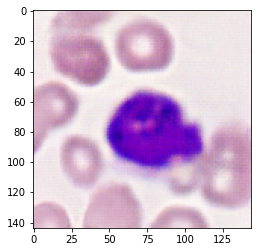

In [29]:
plt.imshow(train_images[0])

# CNN

## Models

### Mobile Net v3 Large

In [30]:
def MobileNet3Large():
    # Define the input shape for the model
    input_shape = SHAPE  # Adjust according to your image size

    # Load the MobileNetV3Large model without the top classification layer
    base_model = tf.keras.applications.MobileNetV3Large(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add a global average pooling layer and a fully connected layer
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)  # Adjust the number of units as needed
    x = tf.keras.layers.BatchNormalization()(x)  # Insert the batch normalization layer here
    x = tf.keras.layers.Activation('relu')(x) 
#     x = tf.keras.layers.Dropout(0.1)(x)
    predictions = tf.keras.layers.Dense(15, activation='softmax')(x)  # Adjust the number of classes

    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

### Xception

In [31]:
def Xception():
    # Define the input shape for the model
    input_shape = SHAPE  # Adjust according to your image size

    # Load the MobileNetV3Large model without the top classification layer
    base_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add a global average pooling layer and a fully connected layer
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)  # Adjust the number of units as needed
    x = tf.keras.layers.BatchNormalization()(x)  # Insert the batch normalization layer here
    x = tf.keras.layers.Activation('relu')(x) 
#     x = tf.keras.layers.Dropout(0.1)(x)
    predictions = tf.keras.layers.Dense(15, activation='softmax')(x)  # Adjust the number of classes

    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

### ResNet50V2

In [32]:
def ResNet50V2():
    # Define the input shape for the model
    input_shape = SHAPE  # Adjust according to your image size

    # Load the MobileNetV3Large model without the top classification layer
    base_model = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add a global average pooling layer and a fully connected layer
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)  # Adjust the number of units as needed
    x = tf.keras.layers.BatchNormalization()(x)  # Insert the batch normalization layer here
    x = tf.keras.layers.Activation('relu')(x) 
#     x = tf.keras.layers.Dropout(0.1)(x)
    predictions = tf.keras.layers.Dense(15, activation='softmax')(x)  # Adjust the number of classes

    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

### VGG16

In [33]:
def VGG16():
    # Define the input shape for the model
    input_shape = SHAPE  # Adjust according to your image size

    # Load the MobileNetV3Large model without the top classification layer
    base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add a global average pooling layer and a fully connected layer
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)  # Adjust the number of units as needed
    x = tf.keras.layers.BatchNormalization()(x)  # Insert the batch normalization layer here
    x = tf.keras.layers.Activation('relu')(x) 
#     x = tf.keras.layers.Dropout(0.1)(x)
    predictions = tf.keras.layers.Dense(15, activation='softmax')(x)  # Adjust the number of classes

    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

### DenseNet121

In [34]:
def DenseNet121():
    # Define the input shape for the model
    input_shape = SHAPE  # Adjust according to your image size

    # Load the MobileNetV3Large model without the top classification layer
    base_model = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add a global average pooling layer and a fully connected layer
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)  # Adjust the number of units as needed
    x = tf.keras.layers.BatchNormalization()(x)  # Insert the batch normalization layer here
    x = tf.keras.layers.Activation('relu')(x) 
#     x = tf.keras.layers.Dropout(0.1)(x)
    predictions = tf.keras.layers.Dense(15, activation='softmax')(x)  # Adjust the number of classes

    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

### InceptionV3

In [35]:
def InceptionV3():
    # Define the input shape for the model
    input_shape = SHAPE  # Adjust according to your image size

    # Load the MobileNetV3Large model without the top classification layer
    base_model = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add a global average pooling layer and a fully connected layer
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)  # Adjust the number of units as needed
    x = tf.keras.layers.BatchNormalization()(x)  # Insert the batch normalization layer here
    x = tf.keras.layers.Activation('relu')(x) 
#     x = tf.keras.layers.Dropout(0.1)(x)
    predictions = tf.keras.layers.Dense(15, activation='softmax')(x)  # Adjust the number of classes

    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

### Select the model

In [36]:
def load_model(model_option):
    if model_option == OPT_MODEL_MOBILENETV3_LARGE:
        return MobileNet3Large()
    if model_option == OPT_MODEL_XCEPTION:
        return Xception()
    if model_option == OPT_MODEL_RESNET50V2:
        return ResNet50V2()
    if model_option == OPT_MODEL_VGG16:
        return VGG16()
    if model_option == OPT_MODEL_DENSENET121:
        return DenseNet121()
    if model_option == OPT_MODEL_INCEPTIONV3:
        return InceptionV3()
    return None

## Train

In [37]:
def train(model, model_train_data_path):
    # save the best model based on the validation KID metric
    checkpoint_path = os.path.join(model_train_data_path,"cnn_model_checkpoint")
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        monitor="val_loss",
        mode="min",
        save_best_only=True,
    )
    
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        min_delta = 0.001,
        patience=20, 
        verbose=0,)
    
    r = model.fit(
        train_images,
        train_labels,
        validation_data=(val_images, val_labels),
        batch_size = batch_size,
        epochs=num_epochs,
        callbacks=[
            checkpoint_callback,
            early_stopping_callback,
        ],
    )
    return r

# Plots & Save

## Save model & history & time

In [38]:
def save_model_history(r,model_train_data_path, train_time):
    model_history = r.history

    r_name = 'history.pickle'
    r_save_path = os.path.join(model_train_data_path, r_name)
    with open(r_save_path, 'wb') as handle:
        pickle.dump(model_history, handle, protocol=pickle.HIGHEST_PROTOCOL)

    train_time_name = 'train_time.txt'
    train_time_save_path = os.path.join(model_train_data_path, train_time_name)
    with open(train_time_save_path, 'w') as handle:
        handle.write(str(train_time))

## Load model & history & time

In [39]:
def load_model_from_disk(model_option,model_train_data_path):
    model = load_model(model_option)
    checkpoint_path = os.path.join(model_train_data_path,"cnn_model_checkpoint")
    model.load_weights(checkpoint_path)
    return model

def load_model_history(model_option, model_train_data_path):
    model = load_model_from_disk(model_option,model_train_data_path)
    
    r_name = 'history.pickle'
    r_save_path = os.path.join(model_train_data_path, r_name)
    
    with open(r_save_path, 'rb') as handle:
        model_history = pickle.load(handle)
    
#     train_time_name = 'train_time.txt'
#     train_time_save_path = os.path.join(model_train_data_path, train_time_name)
#     with open(train_time_save_path, 'r') as file:
#         train_time = file.read().strip()  
#         train_time = float(train_time)  
#     print(train_time)
    
    return model, model_history

## Plot history

In [40]:
def save_plot(model_history,model_train_data_path):
    # Get the metrics from the model history
    metrics = list(model_history.keys())

    # Plot each metric
    for metric in metrics:
        # Get the metric values
        values = model_history[metric]

        # Create the plot
        fig = plt.figure()
        fig.set_figwidth(10)
        fig.set_figheight(10) 
        plt.plot(values)
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.show()

        # Save plot
        plot_path = os.path.join(model_train_data_path, f'{metric}.png')
        fig.savefig(plot_path,bbox_inches='tight', transparent="True", pad_inches=0)

## Test and Confussion Matrix

In [41]:
def test_and_confussion_matrix(model,model_train_data_path, test_loss_data, test_acc_data):
    test = model.evaluate(test_images,test_labels)
    
    update_df(test_loss_data, model_option, test[0])
    update_df(test_acc_data, model_option, test[1])
    
    test_results_name = 'test_results.txt'
    test_results_save_path = os.path.join(model_train_data_path, test_results_name)
    with open(test_results_save_path, 'w') as f:
        f.write(f"loss: {test[0]}\tacc: {test[1]}")

    predictions = model.predict(test_images)
    predictions =np.argmax(predictions, axis=1)
    t_test_arg_max =np.argmax(test_labels, axis=1)

    disp = ConfusionMatrixDisplay.from_predictions(t_test_arg_max, predictions, display_labels=LABELS, colorbar= False,xticks_rotation='vertical')
    fig = disp.ax_.get_figure() 
    fig.set_figwidth(10)
    fig.set_figheight(10)  

    fig_path = os.path.join(model_train_data_path, 'confussion_matrix.png')
    fig.savefig(fig_path,bbox_inches='tight', transparent="True", pad_inches=0)

# Iterate Through Models

Deleting train data of DATASET Synthetic_Dataset
	Deleting ../train_data/FINAL_CNN/Synthetic_Dataset_300EPOCHS_100TRAIN_THRESHOLD/Xception
	Deleting ../train_data/FINAL_CNN/Synthetic_Dataset_300EPOCHS_100TRAIN_THRESHOLD/InceptionV3
	Deleting ../train_data/FINAL_CNN/Synthetic_Dataset_300EPOCHS_100TRAIN_THRESHOLD/VGG16
	Deleting ../train_data/FINAL_CNN/Synthetic_Dataset_300EPOCHS_100TRAIN_THRESHOLD/ResNet50V2
	Deleting ../train_data/FINAL_CNN/Synthetic_Dataset_300EPOCHS_100TRAIN_THRESHOLD/DenseNet121
	Deleting ../train_data/FINAL_CNN/Synthetic_Dataset_300EPOCHS_100TRAIN_THRESHOLD/MobileNetV3Large
Checking train data folder: ../train_data/FINAL_CNN

Checking dataset folder: ../train_data/FINAL_CNN/Synthetic_Dataset_300EPOCHS_100TRAIN_THRESHOLD
	Checking model folder: ../train_data/FINAL_CNN/Synthetic_Dataset_300EPOCHS_100TRAIN_THRESHOLD/MobileNetV3Large
	Checking model folder: ../train_data/FINAL_CNN/Synthetic_Dataset_300EPOCHS_100TRAIN_THRESHOLD/Xception
	Checking model folder: ../train_

2023-07-15 02:12:02.280929: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-15 02:12:03.290972: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-07-15 02:12:03.291012: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14112 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3b:00.0, compute capability: 7.5
/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Ad

../train_data/FINAL_CNN/Synthetic_Dataset_300EPOCHS_100TRAIN_THRESHOLD/MobileNetV3Large
			TRAIN MODEL: MobileNetV3Large
Epoch 1/300


2023-07-15 02:12:14.127651: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2023-07-15 02:12:15.129105: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


118/118 [==============================] - 23s 125ms/step - loss: 2.2018 - accuracy: 0.2915 - val_loss: 2.7943 - val_accuracy: 0.1500
Epoch 2/300
118/118 [==============================] - 10s 84ms/step - loss: 1.8907 - accuracy: 0.3925 - val_loss: 2.9144 - val_accuracy: 0.0333
Epoch 3/300
118/118 [==============================] - 9s 80ms/step - loss: 1.7503 - accuracy: 0.4367 - val_loss: 3.3342 - val_accuracy: 0.0333
Epoch 4/300
118/118 [==============================] - 9s 79ms/step - loss: 1.6550 - accuracy: 0.4702 - val_loss: 3.4978 - val_accuracy: 0.1500
Epoch 5/300
118/118 [==============================] - 10s 82ms/step - loss: 1.5889 - accuracy: 0.4912 - val_loss: 10.4290 - val_accuracy: 0.0333
Epoch 6/300
118/118 [==============================] - 9s 79ms/step - loss: 1.5186 - accuracy: 0.5128 - val_loss: 3.7920 - val_accuracy: 0.2333
Epoch 7/300
118/118 [==============================] - 10s 81ms/step - loss: 1.4625 - accuracy: 0.5269 - val_loss: 5.1764 - val_accuracy: 0.216

/tmp/ipykernel_3281645/4242746551.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df.loc[FOLDER_NAME] = pd.Series()


			SAVE PLOTS: MobileNetV3Large


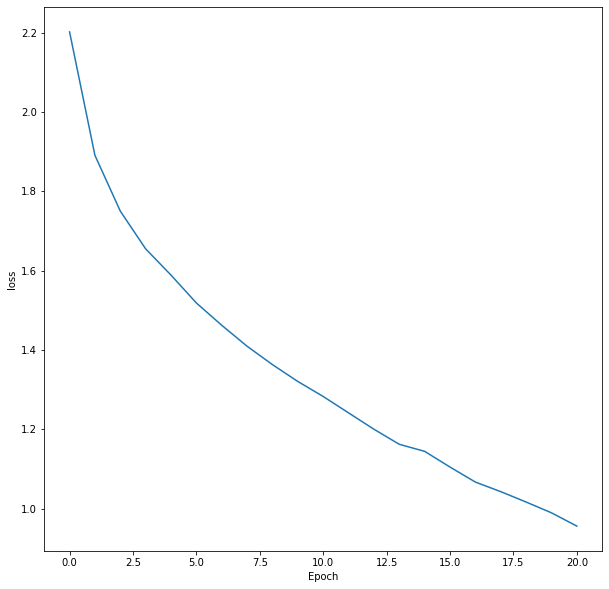

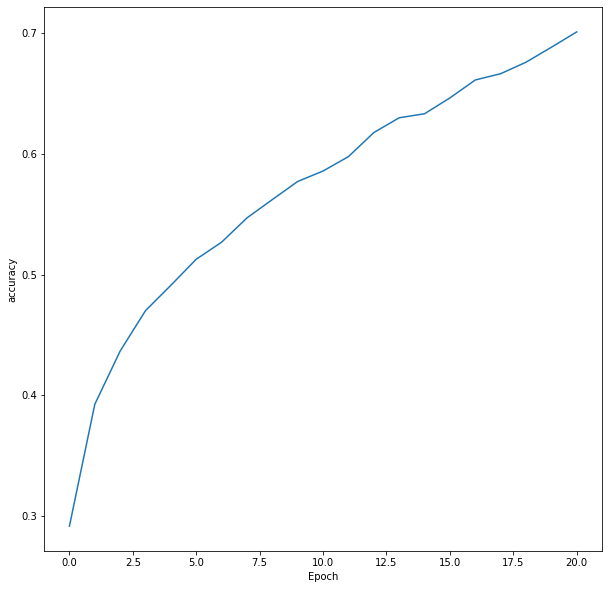

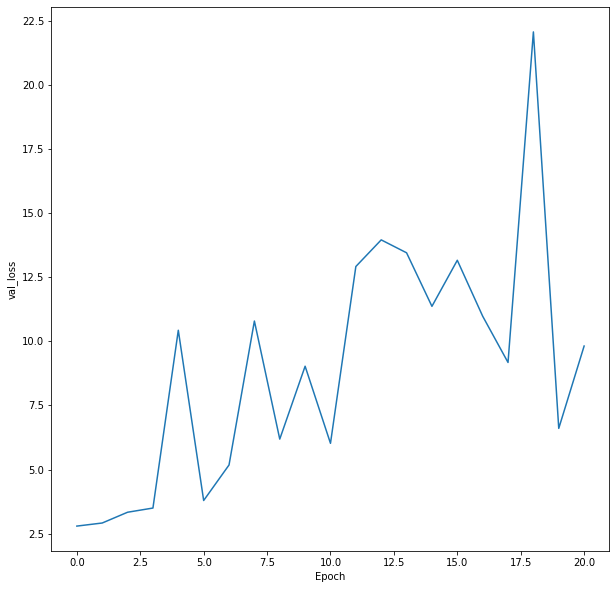

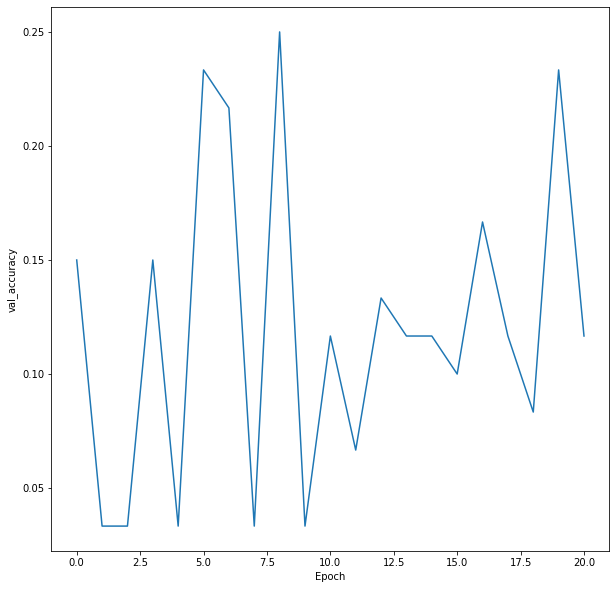

			SAVE TEST AND CONFUSSION MATRIX: MobileNetV3Large
1/1 [==============================] - 1s 1s/step
			LOAD MODEL: Xception


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


../train_data/FINAL_CNN/Synthetic_Dataset_300EPOCHS_100TRAIN_THRESHOLD/Xception
			TRAIN MODEL: Xception
Epoch 1/300
118/118 [==============================] - 36s 255ms/step - loss: 2.2664 - accuracy: 0.2824 - val_loss: 2.1788 - val_accuracy: 0.3000
Epoch 2/300
118/118 [==============================] - 26s 221ms/step - loss: 1.8470 - accuracy: 0.3995 - val_loss: 1.9476 - val_accuracy: 0.3167
Epoch 3/300
118/118 [==============================] - 25s 215ms/step - loss: 1.6851 - accuracy: 0.4545 - val_loss: 2.1246 - val_accuracy: 0.3167
Epoch 4/300
118/118 [==============================] - 26s 224ms/step - loss: 1.5577 - accuracy: 0.4966 - val_loss: 1.9100 - val_accuracy: 0.4000
Epoch 5/300
118/118 [==============================] - 26s 221ms/step - loss: 1.4672 - accuracy: 0.5265 - val_loss: 1.7196 - val_accuracy: 0.4667
Epoch 6/300
118/118 [==============================] - 26s 223ms/step - loss: 1.3730 - accuracy: 0.5599 - val_loss: 1.4898 - val_accuracy: 0.5167
Epoch 7/300
118/118

Epoch 50/300
118/118 [==============================] - 25s 215ms/step - loss: 0.1763 - accuracy: 0.9472 - val_loss: 0.5309 - val_accuracy: 0.8000
Epoch 51/300
118/118 [==============================] - 25s 215ms/step - loss: 0.2136 - accuracy: 0.9316 - val_loss: 0.8451 - val_accuracy: 0.7500
Epoch 52/300
118/118 [==============================] - 25s 215ms/step - loss: 0.1472 - accuracy: 0.9583 - val_loss: 0.5593 - val_accuracy: 0.7667
Epoch 53/300
118/118 [==============================] - 26s 216ms/step - loss: 0.0829 - accuracy: 0.9807 - val_loss: 0.2751 - val_accuracy: 0.9333
Epoch 54/300
118/118 [==============================] - 26s 218ms/step - loss: 0.0660 - accuracy: 0.9862 - val_loss: 0.2231 - val_accuracy: 0.9000
Epoch 55/300
118/118 [==============================] - 26s 221ms/step - loss: 0.0395 - accuracy: 0.9948 - val_loss: 0.1002 - val_accuracy: 0.9833
Epoch 56/300
118/118 [==============================] - 26s 220ms/step - loss: 0.0465 - accuracy: 0.9911 - val_loss: 0

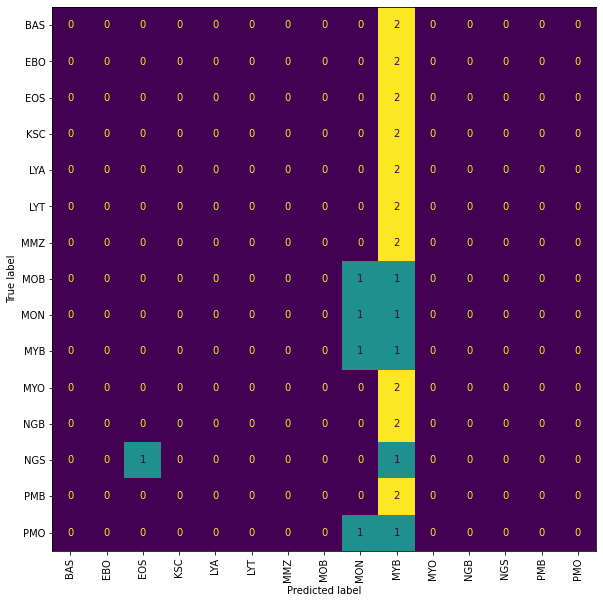

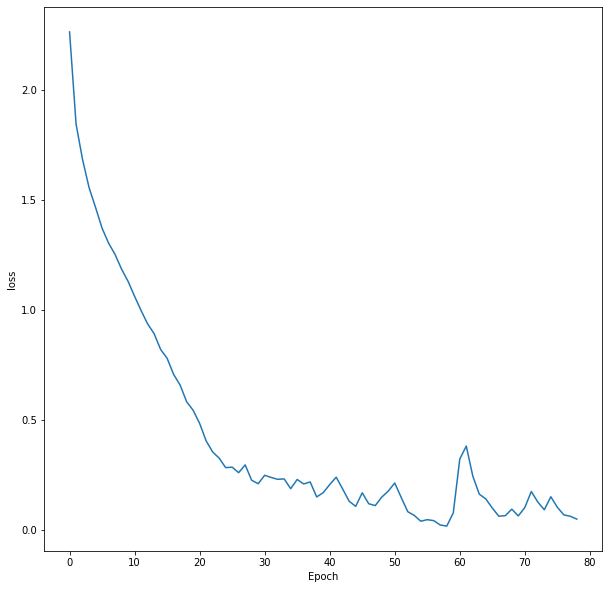

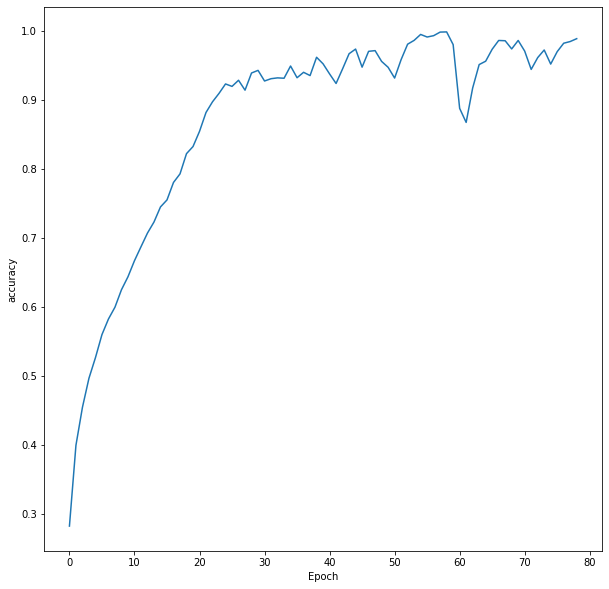

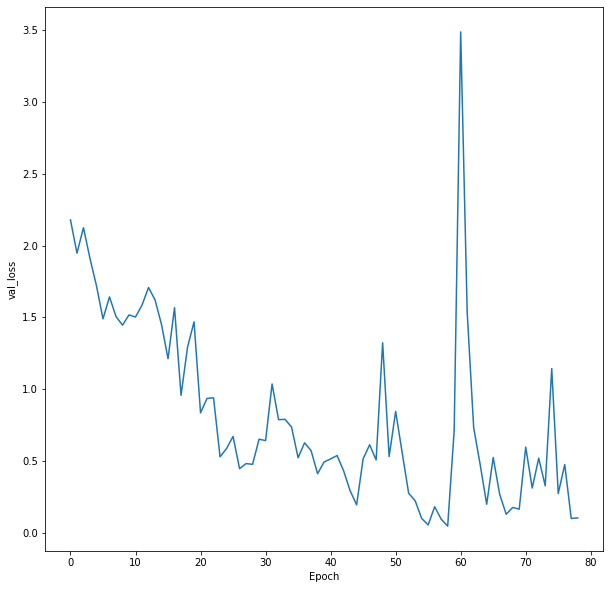

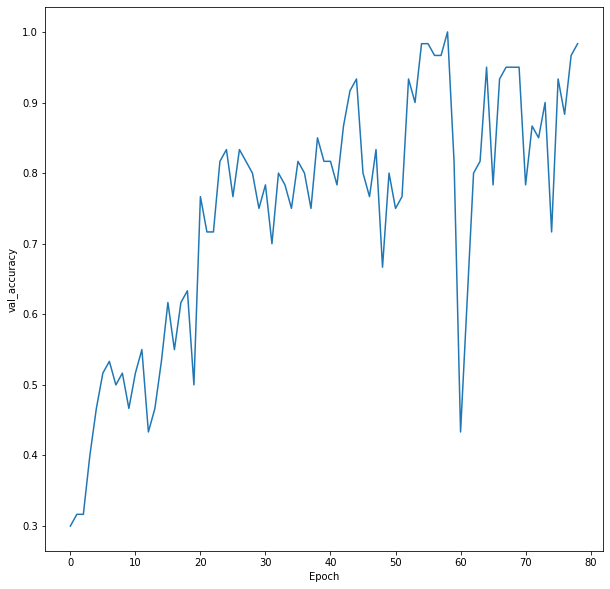

			SAVE TEST AND CONFUSSION MATRIX: Xception
1/1 [==============================] - 1s 698ms/step
			LOAD MODEL: ResNet50V2


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


../train_data/FINAL_CNN/Synthetic_Dataset_300EPOCHS_100TRAIN_THRESHOLD/ResNet50V2
			TRAIN MODEL: ResNet50V2
Epoch 1/300
118/118 [==============================] - 33s 228ms/step - loss: 2.1635 - accuracy: 0.3193 - val_loss: 1.8636 - val_accuracy: 0.3833
Epoch 2/300
118/118 [==============================] - 22s 185ms/step - loss: 1.6250 - accuracy: 0.4780 - val_loss: 1.7078 - val_accuracy: 0.4833
Epoch 3/300
118/118 [==============================] - 22s 184ms/step - loss: 1.3745 - accuracy: 0.5537 - val_loss: 1.4471 - val_accuracy: 0.5500
Epoch 4/300
118/118 [==============================] - 21s 182ms/step - loss: 1.1949 - accuracy: 0.6185 - val_loss: 1.3079 - val_accuracy: 0.6000
Epoch 5/300
118/118 [==============================] - 21s 181ms/step - loss: 1.0714 - accuracy: 0.6656 - val_loss: 1.1867 - val_accuracy: 0.6167
Epoch 6/300
118/118 [==============================] - 21s 177ms/step - loss: 0.9545 - accuracy: 0.7113 - val_loss: 1.2022 - val_accuracy: 0.5667
Epoch 7/300
118

Epoch 50/300
118/118 [==============================] - 21s 177ms/step - loss: 0.0246 - accuracy: 0.9976 - val_loss: 0.0506 - val_accuracy: 0.9833
Epoch 51/300
118/118 [==============================] - 21s 177ms/step - loss: 0.0290 - accuracy: 0.9957 - val_loss: 0.0942 - val_accuracy: 0.9667
Epoch 52/300
118/118 [==============================] - 21s 178ms/step - loss: 0.0788 - accuracy: 0.9783 - val_loss: 0.6305 - val_accuracy: 0.8000
Epoch 53/300
118/118 [==============================] - 21s 177ms/step - loss: 0.2278 - accuracy: 0.9245 - val_loss: 0.8540 - val_accuracy: 0.7167
Epoch 54/300
118/118 [==============================] - 21s 177ms/step - loss: 0.1658 - accuracy: 0.9481 - val_loss: 0.5635 - val_accuracy: 0.7833
Epoch 55/300
118/118 [==============================] - 21s 176ms/step - loss: 0.0720 - accuracy: 0.9826 - val_loss: 0.4099 - val_accuracy: 0.8667
Epoch 56/300
118/118 [==============================] - 21s 176ms/step - loss: 0.0869 - accuracy: 0.9762 - val_loss: 0

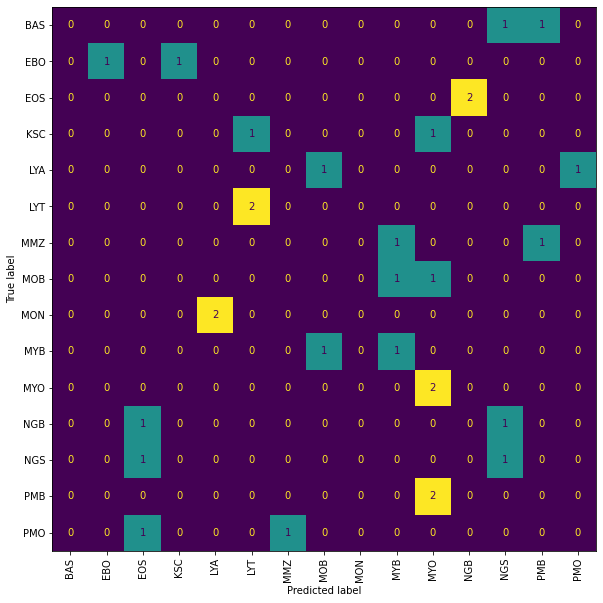

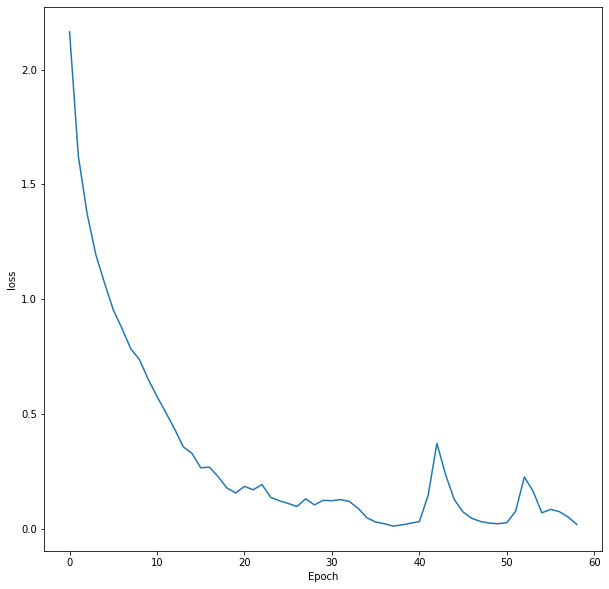

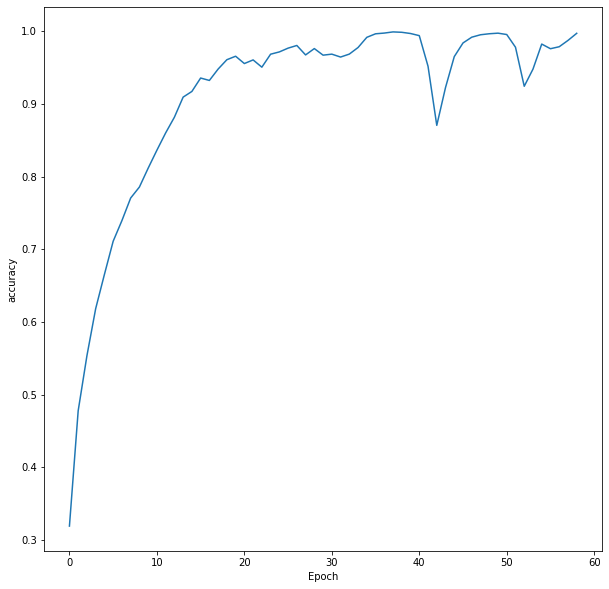

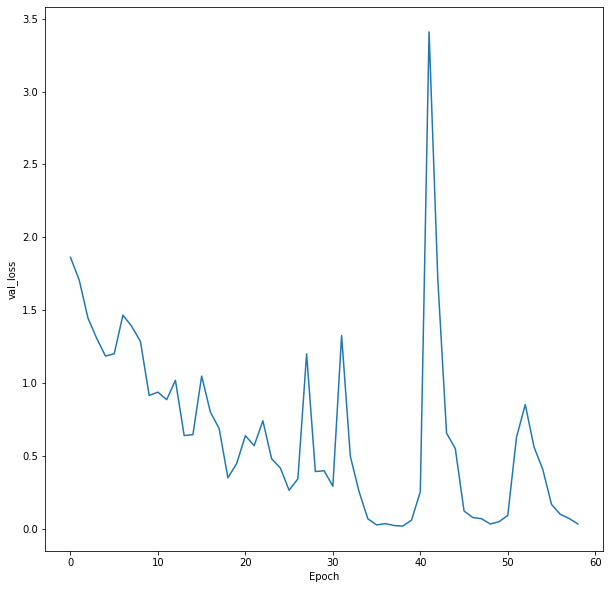

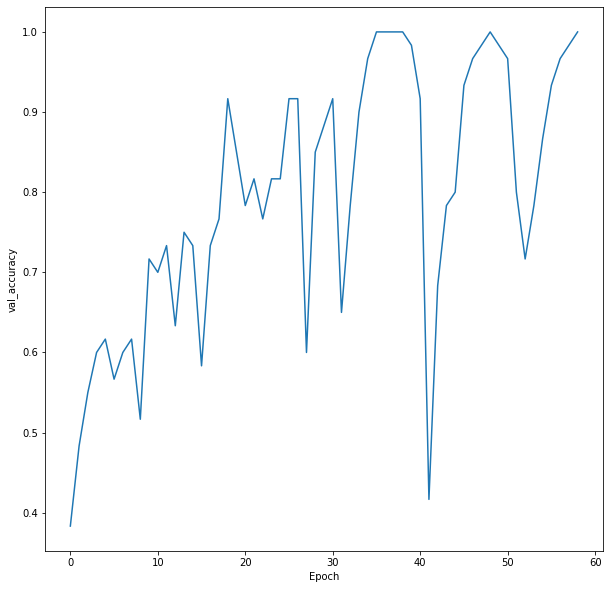

			SAVE TEST AND CONFUSSION MATRIX: ResNet50V2
1/1 [==============================] - 1s 753ms/step
			LOAD MODEL: VGG16


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


../train_data/FINAL_CNN/Synthetic_Dataset_300EPOCHS_100TRAIN_THRESHOLD/VGG16
			TRAIN MODEL: VGG16
Epoch 1/300
118/118 [==============================] - 47s 353ms/step - loss: 2.0957 - accuracy: 0.3269 - val_loss: 2.3713 - val_accuracy: 0.1167
Epoch 2/300
118/118 [==============================] - 36s 307ms/step - loss: 1.7374 - accuracy: 0.4422 - val_loss: 2.1534 - val_accuracy: 0.1667
Epoch 3/300
118/118 [==============================] - 36s 306ms/step - loss: 1.6105 - accuracy: 0.4795 - val_loss: 2.2541 - val_accuracy: 0.2000
Epoch 4/300
118/118 [==============================] - 36s 305ms/step - loss: 1.5172 - accuracy: 0.5045 - val_loss: 2.2382 - val_accuracy: 0.3500
Epoch 5/300
118/118 [==============================] - 36s 305ms/step - loss: 1.4232 - accuracy: 0.5421 - val_loss: 2.0634 - val_accuracy: 0.3333
Epoch 6/300
118/118 [==============================] - 36s 306ms/step - loss: 1.3565 - accuracy: 0.5645 - val_loss: 2.2835 - val_accuracy: 0.3333
Epoch 7/300
118/118 [====

118/118 [==============================] - 36s 303ms/step - loss: 0.0750 - accuracy: 0.9906 - val_loss: 1.0451 - val_accuracy: 0.6833
Epoch 50/300
118/118 [==============================] - 36s 305ms/step - loss: 0.1299 - accuracy: 0.9707 - val_loss: 1.8348 - val_accuracy: 0.6167
Epoch 51/300
118/118 [==============================] - 36s 309ms/step - loss: 0.1216 - accuracy: 0.9722 - val_loss: 1.3250 - val_accuracy: 0.6167
Epoch 52/300
118/118 [==============================] - 36s 304ms/step - loss: 0.1054 - accuracy: 0.9793 - val_loss: 2.1196 - val_accuracy: 0.5500
Epoch 53/300
118/118 [==============================] - 36s 305ms/step - loss: 0.0901 - accuracy: 0.9848 - val_loss: 1.5745 - val_accuracy: 0.6000
Epoch 54/300
118/118 [==============================] - 36s 306ms/step - loss: 0.0682 - accuracy: 0.9905 - val_loss: 0.4863 - val_accuracy: 0.8500
Epoch 55/300
118/118 [==============================] - 36s 308ms/step - loss: 0.0524 - accuracy: 0.9957 - val_loss: 0.2684 - val_a

In [ ]:
delete_train_data()
check_train_data_dirs()
for model_option in [m for m in MODEL_OPTIONS if m not in EXCLUDED_MODELS]:
        
    
    print(f"\t\t\tLOAD MODEL: {model_option}")
    model = load_model(model_option)
    model_train_data_path = os.path.join(DATASET_TRAIN_DATA_PATH, model_option)
    print(model_train_data_path)
    
    
    
    print(f"\t\t\tTRAIN MODEL: {model_option}")
    train_time = time.time()
    r = train(model, model_train_data_path)
    train_time = time.time() - train_time
    
    
    
    print(f"\t\t\tSAVE MODEL HISTORY & TRAIN TIME TXT: {model_option}")
    save_model_history(r,model_train_data_path, train_time)
    
    
    
    print(f"\t\tSAVE TRAIN TIME: {model_option}")
    update_df(train_time_data, model_option, train_time)
    
        
    
    print(f"\t\t\tLOAD MODEL HISTORY: {model_option}")
    model, model_history = load_model_history(model_option, model_train_data_path)
    
    
    
    print(f"\t\t\tSAVE PLOTS: {model_option}")
    save_plot(model_history,model_train_data_path)
    
    
    
    print(f"\t\t\tSAVE TEST AND CONFUSSION MATRIX: {model_option}")
    test_and_confussion_matrix(model,model_train_data_path, test_loss_data, test_acc_data)
    
    

    
train_time_average = calculate_average_df(train_time_data['df'])
print(f"\t\t\tSAVING TRAIN TIME AVERAGE: {train_time_average}")
update_df(train_time_data, 'Average', train_time_average)

loss_average = calculate_average_df(test_loss_data['df'])
print(f"\t\t\tSAVING TEST LOSS AVERAGE: {loss_average}")
update_df(test_loss_data, 'Average', loss_average)

acc_average = calculate_average_df(test_acc_data['df'])
print(f"\t\t\tSAVING TEST ACCURACY AVERAGE: {acc_average}")
update_df(test_acc_data, 'Average', acc_average)
    